## __Install & mount a Drive__

In [1]:
!pip install -q datasets transformers librosa jiwer accelerate

from google.colab import drive
from huggingface_hub import notebook_login

drive.mount("/content/drive")
notebook_login()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 104.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## __1.Load Datasets__

In [3]:
from datasets import load_dataset, Dataset
from itertools import islice

ko = list(islice(load_dataset("mozilla-foundation/common_voice_13_0", "ko", split="train", streaming=True), 100))
en = list(islice(load_dataset("mozilla-foundation/common_voice_13_0", "en", split="train", streaming=True), 100))
ja = list(islice(load_dataset("mozilla-foundation/common_voice_13_0", "ja", split="train", streaming=True), 100))
de = list(islice(load_dataset("mozilla-foundation/common_voice_13_0", "de", split="train", streaming=True), 100))

dataset = Dataset.from_list(ko + en + ja + de)

common_voice_13_0.py:   0%|          | 0.00/8.18k [00:00<?, ?B/s]

languages.py:   0%|          | 0.00/3.65k [00:00<?, ?B/s]

release_stats.py:   0%|          | 0.00/65.4k [00:00<?, ?B/s]

The repository for mozilla-foundation/common_voice_13_0 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/mozilla-foundation/common_voice_13_0.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Reading metadata...: 192it [00:00, 682.53it/s]
Reading metadata...: 1013968it [00:21, 46739.40it/s]
Reading metadata...: 7071it [00:00, 18937.68it/s]
Reading metadata...: 540437it [00:11, 46679.83it/s]


## __2.Whisper-tiny__

In [4]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration

checkpoint = "openai/whisper-tiny"

processor = WhisperProcessor.from_pretrained(checkpoint, language=None, task="transcribe")
model = WhisperForConditionalGeneration.from_pretrained(checkpoint)
model.config.forced_decoder_ids = None
model.config.suppress_tokens = []

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.98k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/151M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.75k [00:00<?, ?B/s]

## __3.Preprocessing__

In [5]:
def prepare_dataset(example):
    audio = example["audio"]
    example["input_features"] = processor.feature_extractor(audio["array"], sampling_rate=16000).input_features[0]
    example["labels"] = processor.tokenizer(example["sentence"]).input_ids
    return example

processed_dataset = dataset.map(prepare_dataset, remove_columns=dataset.column_names)

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

In [6]:
#DataCollator정의
from dataclasses import dataclass
from typing import Any, Dict, List, Union
import torch

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_features": f["input_features"]} for f in features]
        label_features = [{"input_ids": f["labels"]} for f in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)
        batch["labels"] = labels
        return batch

data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)


In [7]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/WhisperCheckpoints/run_multi_tiny_trial1",
    per_device_train_batch_size=4,
    learning_rate=1e-5,
    num_train_epochs=3,
    logging_steps=5,
    save_strategy="epoch",
    fp16=True,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=processed_dataset,
    tokenizer=processor,
    data_collator=data_collator
)

<ipython-input-7-536ac11e8ea3>:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## __4.Training__

In [8]:
trainer.train()

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss
5,6.938000
10,5.822700
15,5.618900
20,5.306600
25,4.665600
30,4.991200
35,4.492200
40,4.456100
45,4.409400
50,4.398300


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 448, 'suppress_tokens': [], 'begin_suppress_tokens': [220, 50257]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=300, training_loss=3.4254807885487875, metrics={'train_runtime': 163.6703, 'train_samples_per_second': 7.332, 'train_steps_per_second': 1.833, 'total_flos': 2.9542662144e+16, 'train_loss': 3.4254807885487875, 'epoch': 3.0})

In [9]:
save_path = "/content/drive/MyDrive/WhisperCheckpoints/run_multi_tiny_trial1"
model.save_pretrained(save_path)
processor.save_pretrained(save_path)

[]

## __5.Prediction__

In [10]:
import torch
from jiwer import wer
from tqdm import tqdm

def filter_by_lang(dataset, lang_code):
    return [x for x in dataset if x["locale"] == lang_code]

lang_list = ["ko", "en", "ja", "de"]
lang_wer_results = {}

for lang in lang_list:
    print(f"\n🌍 Language: {lang}")
    lang_data = filter_by_lang(dataset, lang)
    predictions, references = [], []

    for sample in tqdm(lang_data):
        input_features = processor.feature_extractor(sample["audio"]["array"], sampling_rate=16000, return_tensors="pt").input_features.to(model.device)

        with torch.no_grad():
            predicted_ids = model.generate(input_features)

        transcription = processor.tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)[0]
        predictions.append(transcription)
        references.append(sample["sentence"])

        print(f"\n🔹 Predicted: {transcription}")
        print(f"🔸 Reference: {sample['sentence']}")

    score = wer(references, predictions)
    lang_wer_results[lang] = score
    print(f"\n✅ {lang.upper()} WER: {score:.4f}")


🌍 Language: ko


  0%|          | 0/100 [00:00<?, ?it/s]Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
  1%|          | 1/100 [00:00<01:14,  1.34it/s]


🔹 Predicted: Ane er hat er ein paar Jahre später eine andere Landwirtis in der Beratung von Zubar.
🔸 Reference: 어느덧 그 더운 팔월도 하루를 남기고 다 지나 버렸다.


  3%|▎         | 3/100 [00:01<00:31,  3.10it/s]


🔹 Predicted: 든지 전에도는 그 사이에는 그 사이에서는 그 바다가 흔들어.
🔸 Reference: 근자에 춘우의 동료 사이에는 이상한 소문이 돌아다니었다.

🔹 Predicted:  그치 자기로는 소리가 듣고 그정도 눈치지 않다.
🔸 Reference: 재차 부르는 소리를 듣고야 선비는 발길을 떼었다.


  4%|▍         | 4/100 [00:01<00:25,  3.79it/s]


🔹 Predicted: Keyback of some of the chosen oversumming team in the Gannner.
🔸 Reference: 그애의 말값으로 찾아나 봤으면 되는 것 아니냐.


  6%|▌         | 6/100 [00:04<01:26,  1.08it/s]


🔹 Predicted: Kirrekehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehmehme
🔸 Reference: 그가 방으로 들어오니 간난이가 와서 그의 하던 일을 하고 있었다.

🔹 Predicted: Amyte Nauwisier
🔸 Reference: 안녕히 다녀옵시요.


  8%|▊         | 8/100 [00:05<00:49,  1.87it/s]


🔹 Predicted: あたくぼくと仕上げやはり、すみにし、あんだら、すぎや、おそつもり、すみをつく
🔸 Reference: 어떻게 무엇부터 시작을 해야 할는지 엄두가 나지를 않아서 잠을 잘 수가 없었다.

🔹 Predicted: シンのような形に入れば
🔸 Reference: 죽는 날까지 하늘을 우러러


 10%|█         | 10/100 [00:08<01:30,  1.00s/it]


🔹 Predicted: 国陆大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪大阪
🔸 Reference: 그리고 그 어두운 방 안이 휙 지나친다.

🔹 Predicted: 上の中を歩くとしぶって
🔸 Reference: 왜 눈을 바루 뜨지 못해!


 12%|█▏        | 12/100 [00:08<00:52,  1.68it/s]


🔹 Predicted:  오신은 바라던가로 하다간다. 그는 시계소가가 미치수가 있었다.
🔸 Reference: 영신은 바라던 대로 바닷가 한가한 집에서 편안히 쉴 수가 있었다.

🔹 Predicted:  저녁에 싸우는 저의 흥립이 얻었었죠.
🔸 Reference: 잡을 수 없는 저 하늘의 별도 잡자.


 13%|█▎        | 13/100 [00:12<02:03,  1.41s/it]


🔹 Predicted: かわもももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももももも
🔸 Reference: 하고, 목메인 소리가 뒤를 따랐다.


 15%|█▌        | 15/100 [00:15<02:00,  1.41s/it]


🔹 Predicted: Kudi wo kiei arn oha kudi wo kiei arn oha kudi wo kiei arn oha kudi wo kiei arn oha kudi wo kiei arn oha kudi wo kiei arn oha kudi wo kiei arn oha kudi wo kiei arn oha kudi wo kiei arn oha kudi wo kiei arn oha kudi wo kiei arn oha kudi wo kiei arn oha kudi wo kiei arn oha kudi wo kiei arn oha kudi wo kiei arn oha kudi wo kiei arn oha kudi wo kiei arn oha kudi wo kiei arn oha kudi wo kiei arn oha kudi wo kiei arn oha kudi wo kiei arn oha kudi wo kiei arn oha kudi wo kiei arn oha kudi wo kiei arn oha kiei arn oha kiei arn oha kiei arn oha kiei arn oha kiei arn oha kiei arn oha kiei arn oha kiei arn oha kiei arn oha kiei arn oha kiei arn oha kiei arn oha kiei arn oha kiei arn oha kiei arn oha kiei arn oha kiei arn oha kiei arn oha kiei arn oha kiei arn oha kiei arn oha kiei arn oha kiei arn oha kiei arn oha kiei arn oha kiei arn
🔸 Reference: 그리고 그의 하던 말을 곰곰이 되풀이하였다.

🔹 Predicted: 岡山の広島に北を教える
🔸 Reference: 영원한 것이 어디 있는가?


 16%|█▌        | 16/100 [00:15<01:29,  1.07s/it]


🔹 Predicted: ほうすみで、そろそろしたら、僕が、キャラの気がつくんやり合った
🔸 Reference: 그것은 예수가 십자가에 못박히며 최후로 부르짖은 말이었다.


 17%|█▋        | 17/100 [00:16<01:08,  1.22it/s]


🔹 Predicted: ときに、一緒に、誰にも、誰にも、誰にも、誰にも、誰にも、
🔸 Reference: 그 틈에 그 짐짝은 딴놈이 메고 달아난다.


 18%|█▊        | 18/100 [00:19<02:08,  1.57s/it]


🔹 Predicted:  친한 이다인신다 이다 그의하는 새 앞봄서 흔냈을 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수 없던 그의 수
🔸 Reference: 그는 이러한 생각을 되풀이하는 새 벌써 간난네 집까지 왔다.


 20%|██        | 20/100 [00:19<01:10,  1.13it/s]


🔹 Predicted: 여지 떨어질 적이 없을 것이고, 이런 것도는 정리를 낭무 낭지, 그가가 더 큰 것이었습니다.
🔸 Reference: 양식 떨어진 사람이 보릿고개를 넘기는것만치 나 까마아득한 것 같습니다.

🔹 Predicted: Pasier binie mit Schöre-Säge-Werwarte.
🔸 Reference: 그래서 그는 억지로 웃어 보이고 말았다.


 22%|██▏       | 22/100 [00:20<00:41,  1.86it/s]


🔹 Predicted: やめたりするや、チーズを取り上げると、気にすぐってやめた
🔸 Reference: 연해 꾸짖으며 질팡갈팡 뛰는 수밖에 없었다.

🔹 Predicted: 岡田県の一部の写真を採取ができる。
🔸 Reference: 영신을 눕히고 자세히 진찰을 해본다.


 24%|██▍       | 24/100 [00:20<00:26,  2.87it/s]


🔹 Predicted: 私は、手の方があるので、
🔸 Reference: 몇 시 퇴근하려고?

🔹 Predicted: きっとにお話を出すような話にさらもお話を出すと
🔸 Reference: 국회는 의원의 자격을 심사하며, 의원을 징계할 수 있다.


 25%|██▌       | 25/100 [00:24<01:32,  1.24s/it]


🔹 Predicted: あたりあんまりでもでもチェックをうちにしよう、ついであんまりでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでもでも
🔸 Reference: 아담이 모든 육축과 공중의 새와 들의 모든 짐승에게 이름을 주니라


 26%|██▌       | 26/100 [00:24<01:09,  1.06it/s]


🔹 Predicted:  그 뒤에 대답지 않든식들이 의원으로 두고 대신 의원을 얻으러 왔던가.
🔸 Reference: 그 뒤로 게 딱지 같은 집들이 오글오글 쫓겨서 몰려들어 간다.


 27%|██▋       | 27/100 [00:24<00:52,  1.38it/s]


🔹 Predicted: 僕の気をしてもいいや、これもあるようにも同じの仕事だった。
🔸 Reference: 그리고 그의 옷이 땀에 배어 어룽어룽하니 말라진 것을 보았다.

🔹 Predicted: ちなみに、やべすぎや、きちじん、なすぎだった。
🔸 Reference: 춘우는 자기 아버지가 약주 취하신 것을 알았다.


 29%|██▉       | 29/100 [00:24<00:31,  2.24it/s]


🔹 Predicted: 自己のような存在は、自己のように与えられた
🔸 Reference: 찌르릉 하고 창자에 퍼지며 얼굴이 화끈하였다.


 30%|███       | 30/100 [00:28<01:30,  1.29s/it]


🔹 Predicted: Aganen kada-sarit-Agan-Sarit-Agan-Sarit-Agan-Agan-Sarit-Agan-Agan-Sarit-Agan-Agan-Sarit-Agan-Agan-Sarit-Agan-Sarit-Agan-Agan-Sarit-Agan-Sarit-Agan-Sarit-Agan-Sarit-Agan-Sarit-Agan-Sarit-Agan-Sarit-Agan-Sarit-Agan-Sarit-Agan-Sarit-Agan-Sarit-Agan-Sarit-Agan-Sarit-Agan-Sarit-Agan-Sarit-Agan-Sarit-Agan-Sarit-Agan-Sarit-Agan-Sarit-Agan-Sarit-Agan-Sarit-Agan-Sarit-Agan-Sarit-Agan-Sarit-Agan-Sarit-Agan-Sarit-Agan-Sarit-Agan-Sarit-Agan-Sarit-Agan-Sarit-Agan-Sarit-Agan-Sarit-Agan-Sarit-Agan-Sarit-Agan-Sarit-Agan-Sarit-Agan-Sarit-Agan-Sarit-Agan-Sarit-Agan-Sarit-Agan-Sarit-Agan-Sarit-Agan-Sarit-Agan-Sarit-Agan-Sarit-Agan-Sarit-Agan-Sarit-Agan-Sarit-Agan-Sarit-Agan-Sarit-Agan-Sarit-Agan-Sarit-Agan-Sarit
🔸 Reference: 바람은 파도 소리처럼 쏴아쏴아 하고 머리 맡에서 뒤설렌다.


 31%|███       | 31/100 [00:28<01:06,  1.03it/s]


🔹 Predicted: シンアイリーの出さずに、バランはやり方に行く
🔸 Reference: 춘우에게 이 모든 사정의 말을 하여 버릴까.


 32%|███▏      | 32/100 [00:31<01:52,  1.66s/it]


🔹 Predicted: きりゃにするのが、それが今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、今、
🔸 Reference: 길 가는 사람이 걱정을 하리만큼 그의 걸음은 황급하였다.


 34%|███▍      | 34/100 [00:35<01:42,  1.56s/it]


🔹 Predicted:  소문은 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그는 그
🔸 Reference: 선비는 간난이가 저렇게 늦게 돌아올 때마다 무엇을 깊이 생각하는 것이 수상스러웠다.

🔹 Predicted:  Tod und anderen bepüßen und schließt sich die Ersinnung.
🔸 Reference: 부엌은 아름답게 장식되었습니다.


 35%|███▌      | 35/100 [00:35<01:14,  1.14s/it]


🔹 Predicted:  심지어는 난은이 가슴으로 돌아올 것 같다.
🔸 Reference: 신철이는 할멈이 깨었으므로 그만 낙망을 하였다.


 36%|███▌      | 36/100 [00:35<00:55,  1.16it/s]


🔹 Predicted:  늙지 않으면 그가의 목소리가 들을 것 같지 않는지 알았다.
🔸 Reference: 납작한 얼굴을 쳐들고 첫째의 눈치를 살살 본다.


 38%|███▊      | 38/100 [00:35<00:31,  1.96it/s]


🔹 Predicted: 当たら県の県の県が近く、全然町の広島にある
🔸 Reference: 아담과 그 아내가 여호와 하나님의 낯을 피하여 동산 나무 사이에 숨은지라

🔹 Predicted: 그는 두 번째가의 입고있습니다.
🔸 Reference: 나는 두 번째 그에게 물었습니다.


 39%|███▉      | 39/100 [00:39<01:21,  1.34s/it]


🔹 Predicted: うそし、リリスは、リリスは、リリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリリ
🔸 Reference: 무소식이 희소식이다


 40%|████      | 40/100 [00:39<01:00,  1.01s/it]


🔹 Predicted: 그는 대답 대신에 나의 흥렬을 낳을 수 있으러 싶어.
🔸 Reference: 그는 대답 대신에 늘 이렇게 웃는 것이 버릇이다.


 42%|████▏     | 42/100 [00:39<00:33,  1.71it/s]


🔹 Predicted:  그저가 의각 지식을 억울한 것과의 공격을 억울한 것과의 사회가
🔸 Reference: 대저 너희가 지식을 미워하며 여호와 경외하기를 즐거워하지 아니하며

🔹 Predicted: 県庫設定的書県庫
🔸 Reference: 경기 시작됐습니다.


 43%|████▎     | 43/100 [00:39<00:28,  2.01it/s]


🔹 Predicted:  송아리의 띠스와의 물이 담어 대체로서 등무의 억대하며 대척다.
🔸 Reference: 선비는 육백삼호인 가마 곁으로 와서 동무의 어깨를 가볍게 쳤다.


 45%|████▌     | 45/100 [00:40<00:19,  2.86it/s]


🔹 Predicted:  그의 저처럼 나나와 린 암 린을 임몰고 깊은 지하십니까.
🔸 Reference: 그래서 간난 어머니는 눈을 둥그렇게 뜨고 눈치를 살폈다.

🔹 Predicted:  그저 또는 그 눈에 눈에 눈을 저와 들은 게 싫다.
🔸 Reference: 그러자 엉엉 하고 우는 개똥이의 곡성을 들은 듯싶다.


 46%|████▌     | 46/100 [00:40<00:16,  3.35it/s]


🔹 Predicted: Kanab was also a book writer, who was also a musician of Saka.
🔸 Reference: 그러나 무엇이라고 꼭 집어대어 철수와 같이 술술 지껄일수는 없었다.


 47%|████▋     | 47/100 [00:40<00:15,  3.50it/s]


🔹 Predicted:  그는 의식이 동의하자 있는 것에 한친다고 진진발도 한한한 그의하는 것이다.
🔸 Reference: 고난의 시기에 동요하지 않는 것은 진정 칭찬받을 만한 뛰어난 인물의 증거다.


 48%|████▊     | 48/100 [00:41<00:14,  3.68it/s]


🔹 Predicted:  가우신은 다시 그의 집주시신을 하여자 한가의 띄우스 온대
🔸 Reference: 영신은 다시 부르짖듯이 신앙의 대상자에게 호소한다.


 49%|████▉     | 49/100 [00:41<00:13,  3.67it/s]


🔹 Predicted: けれども, 선비의 그 그의 나의 의의 소라의 뒷으로 지나치는 것을 그는 확실히 들어간다.
🔸 Reference: 그리고 선비의 그 고운 얼굴이 미소를 띠고 지나치는 것을 그는 확실히 보았다.


 51%|█████     | 51/100 [00:41<00:10,  4.60it/s]


🔹 Predicted: 다운이 들으나 뱉지 않으나 뱉은 김아노가 싼다다.
🔸 Reference: 나의 교훈을 받지 아니하고 나의 모든 책망을 업신여겼음이라

🔹 Predicted:  기차는 저의 운명과
🔸 Reference: 개천에서 용 난다


 52%|█████▏    | 52/100 [00:42<00:11,  4.23it/s]


🔹 Predicted: 라면 그 안에 부부가 오는 순간, 그 안에 그까지 긴 장득으로 운전자 시원하셨으나.
🔸 Reference: 나는 그 알레그로가 울리어 나오는 순간 마음은 끝까지 긴장되고 흥분되었습니다.


 53%|█████▎    | 53/100 [00:42<00:10,  4.29it/s]


🔹 Predicted:  손 띠다 이 흔들냐가 오는지가 벌써 거의 일한 일에 온다.
🔸 Reference: 선비가 이 공장에 들어온 지가 벌써 거의 일년이 되어 온다.


 54%|█████▍    | 54/100 [00:42<00:10,  4.35it/s]


🔹 Predicted: ぼうそぐといったようなような形のような気が入り方にすると
🔸 Reference: 벌써부터 이런 생각을 가졌으나 용이하게 기회를 타는 수가 없었다.


 55%|█████▌    | 55/100 [00:42<00:10,  4.19it/s]


🔹 Predicted: Kinan trinit doga, uran trinit erau, sin trit erau, muoseoseoseppe.
🔸 Reference: 그는 종잇조각과 연필을 내어 신철에게 무엇을 써서 보였다.


 56%|█████▌    | 56/100 [00:45<00:50,  1.15s/it]


🔹 Predicted: 々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々々
🔸 Reference: 헌법재판소 재판관은 정당에 가입하거나 정치에 관여할 수 없다.


 57%|█████▋    | 57/100 [00:46<00:37,  1.16it/s]


🔹 Predicted: Jubaran,川県市から会員がなく、県民に行った。
🔸 Reference: 이번엔 제법 목소리가 패인 남학생의 질문이 들어왔다.


 58%|█████▊    | 58/100 [00:46<00:28,  1.48it/s]


🔹 Predicted: 상은 보나식대로 억무한 시퇴가의 흔돌아지 마다.
🔸 Reference: 한번의 실패와 영원한 실패를 혼동하지 마라.


 60%|██████    | 60/100 [00:49<00:42,  1.07s/it]


🔹 Predicted: 同学に国会会所传々に国会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会会
🔸 Reference: 방망이 소리는 그가 걸을수록 점점 희미하게 들렸다.

🔹 Predicted:  그와당의 그는 한 정무가의 사회의가 같은가
🔸 Reference: 모든 국민은 학문과 예술의 자유를 가진다.


 62%|██████▏   | 62/100 [00:50<00:23,  1.59it/s]


🔹 Predicted:  곧선 드는 두고장은 곧선 본인의 편안하게 깨고 온지 않지만, 그는 이 대가 진떡다.
🔸 Reference: 학생 또는 보호자는 학생 본인에 관한 학교 기록을 언제든지 열람할 권리를 가진다.

🔹 Predicted:  그난 감은 이 대척도 들었다.
🔸 Reference: 그는 담 밑에 착 붙어 섰다.


 63%|██████▎   | 63/100 [00:53<00:52,  1.41s/it]


🔹 Predicted:  소방은 왜 질기? 그의 흥득한가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가
🔸 Reference: 사랑은 말이지, 소유하는 게 아니야.


 65%|██████▌   | 65/100 [00:53<00:27,  1.27it/s]


🔹 Predicted:  저의 난이도 다니두와 그 소금소고는 얇게를 하였다.
🔸 Reference: 효애는 여전히 뭐라고 소곤소곤 이야기를 하였다.

🔹 Predicted:  정신 뒤에 사연 드는 척당의 전혀 정신이 없다.
🔸 Reference: 점심 뒤에 회원들은 잡담을 하며 잠시 쉬었다.


 67%|██████▋   | 67/100 [00:57<00:37,  1.13s/it]


🔹 Predicted:  이런식은 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야 그저야
🔸 Reference: 영신은 그제야 그전에 백씨의 집에서 들은 동혁의 말을 되풀이하듯 하였다.

🔹 Predicted:  사회가 나의 마음을 알았지만 사회의의 의자의 마음을
🔸 Reference: 세상에 나의 마음을 알아 주는 사람이 어디 있어야죠.


 68%|██████▊   | 68/100 [00:57<00:27,  1.18it/s]


🔹 Predicted:  도와주지지 마요 조금들끈이 편한 것이었다.
🔸 Reference: 부르짖으며 저 혼자 감격하는 것이었다.


 69%|██████▉   | 69/100 [00:57<00:21,  1.42it/s]


🔹 Predicted: 自由は、だが、その隠々、自分から、私、その、大な、絶対、その、その、絶対、私、私、私、私、私、
🔸 Reference: 두 아들은 방 속에다 죽은 그 아버지의 송장을 제쳐놓고 서로 잡아삼킬 듯이 다투고 있었습니다.


 71%|███████   | 71/100 [00:58<00:13,  2.22it/s]


🔹 Predicted:  여자가 편의점으로 가야 되요. 동전의 여식으로 가야 우리가 무보신 수는
🔸 Reference: 여자가 뱀에게 말하되 동산 나무의 실과를 우리가 먹을 수 있으나

🔹 Predicted:  그 방은 그 바퀴의 징자가 보니깐다.
🔸 Reference: 국가는 국가표준제도를 확립한다.


 73%|███████▎  | 73/100 [00:58<00:09,  2.94it/s]


🔹 Predicted: たら、もっと、いろいろ、もち、あつま、もち、かで、ファンザー、しん、もろ、そば、
🔸 Reference: 다른 누구에게도 의지하지 말고 오직 그대 혼자의 힘으로 하라.

🔹 Predicted:  아이고는 의자랑 적절하고 인간을 얻었다.
🔸 Reference: 까불이는 의자를 버쩍 들어 옮겨 놔주었다.


 75%|███████▌  | 75/100 [00:59<00:06,  3.95it/s]


🔹 Predicted:  그가 그와의 그 나라 이런 걸 하셨다.
🔸 Reference: 그가 좋아할 때마다 이런 버릇이 있었다.

🔹 Predicted:  저녁도 한 방은 우정으로부터 소마를 깨진다.
🔸 Reference: 탄핵결정은 공직으로부터 파면함에 그친다.


 77%|███████▋  | 77/100 [00:59<00:05,  4.00it/s]


🔹 Predicted:  한편으로 그가의 오니시나의 차이 수인한다고 그의 오니가 이 아래로 덧끝도 보았니다.
🔸 Reference: 한편으로 그가 영신을 될 수 있는 대로 호의로써 이해하려는 것도 물론이다.

🔹 Predicted: その人を見ると、私は考えたことが同じ事を考えた
🔸 Reference: 선비는 얼굴이 뻘개서 가마에서 뽑혀 나오는 실끝을 들여다보았다.


 78%|███████▊  | 78/100 [01:02<00:25,  1.15s/it]


🔹 Predicted: Much hat daa du besignete, kann nuna nann an du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du du

 79%|███████▉  | 79/100 [01:06<00:37,  1.78s/it]


🔹 Predicted:  신저 빌난은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운 저라운 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운은 저라운 저라운 저라운 저라운 저라운 저라운 저라운 저라운 저라운 저라운 저라운 저라운 저라운 저라운 저라운 저라운 저라운 저라운 저라운 저라운 저라운 저라운 저라운 저라운 저라운 저라운 저라운 저라운 저라운 저라운 저라운 저라운 저라운 저라운 저라운 저라운 저라운 저라운 저라운 저라운 저라운 저라운 저라운 저라운
🔸 Reference: 신철이는 영철의 우는 소리를 들으며 문밖을 나섰다.


 80%|████████  | 80/100 [01:06<00:26,  1.33s/it]


🔹 Predicted:  우당수하고 흥량지의 도전을 보러 왔습니다. 이의 비밀과 생각하여 도움이 없었다.
🔸 Reference: 혹은 사오십 년 뒤에 조선을 무대로 생겨날 이야기라고 생각하여도 좋다.

🔹 Predicted:  그의 미소가서
🔸 Reference: 어디서 오셨어요?


 82%|████████▏ | 82/100 [01:06<00:14,  1.25it/s]


🔹 Predicted: とくも、みんなの一緒について、そんび、おまんじりと、僕のことがある。
🔸 Reference: 덕호는 문 안에 선 채 선비 어머니를 바라보며 걱정을 한다.


 83%|████████▎ | 83/100 [01:10<00:24,  1.41s/it]


🔹 Predicted:  그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의 그의
🔸 Reference: 그리고 무어라고 손질을 두어 번 치고 모밀 밭뒤로 사라진다.


 84%|████████▍ | 84/100 [01:10<00:18,  1.13s/it]


🔹 Predicted:  생비밀의 지압을 부면 지자의 나나가 피하자랑도 깨끗해서 그논을 두껍고 싶다.
🔸 Reference: 선비는 씨아틀도 만지지 않으면 앞이 허전한 것 같아서 그냥 붙들고 있었다.


 85%|████████▌ | 85/100 [01:10<00:13,  1.11it/s]


🔹 Predicted: 두시에 정보나 더 더 낙고놀이 그의 전신을 못한 뒤의 스톱하였다.
🔸 Reference: 동시에 잠깐 잊었던 아픔이 그의 전신을 못 견디게 습격하였다.


 86%|████████▌ | 86/100 [01:11<00:10,  1.38it/s]


🔹 Predicted:  첫째는 이런 저의 무볶다가 다시 그 그의 지회를 한 벗기까지 돌아서 그의 집으로 왔다.
🔸 Reference: 첫째는 무정처하고 걷다가 다시 덕호의 집 주위를 한 바퀴 돌아서 그의 집으로 왔다.


 88%|████████▊ | 88/100 [01:11<00:05,  2.16it/s]


🔹 Predicted: さらに、通りのさり、どれらの場所にしてほう。
🔸 Reference: 사회 교화자로서의 의견을 말씀해주십쇼."

🔹 Predicted:  그는 마치 날과 자극의 의식을 붙여 보다
🔸 Reference: 그는 마침내 구역질을 욱 하고 하였다.


 90%|█████████ | 90/100 [01:11<00:03,  3.08it/s]


🔹 Predicted:  전우와 가랑 조인 뒤 들어와 전우와 노록아들의 든 차량으로 손하였다.
🔸 Reference: 장로와 다른 교인들이 들어와 병원으로 가기를 번차례로 권하였다.

🔹 Predicted:  그의 적은은 참을 쳐봐요.
🔸 Reference: 그래서 그는 잘못 찾아왔는가 하여 도로 나와서 주저하다가 다시 들어갔다.


 91%|█████████ | 91/100 [01:11<00:02,  3.74it/s]


🔹 Predicted: 너는 마음이 곁떡도 없이
🔸 Reference: 나는 아무 걱정도 없이


 92%|█████████▏| 92/100 [01:12<00:02,  3.39it/s]


🔹 Predicted: ภันันด้วยน้าภันที่เป็นกันด้วยนะธานที่เป็นกันด้วยนะ
🔸 Reference: 평안도 어느 산 깊은 금덤판.


 93%|█████████▎| 93/100 [01:12<00:02,  3.41it/s]


🔹 Predicted:  대답도 그가 양도가 만장도 바깥으로 피곤하진요. 김천지에 뒤쳐서 마시려.
🔸 Reference: 비록 고구라 양복일 망정 노박이로 비를 맞으며 김첨지를 뒤쫓아 나왔으랴.


 94%|█████████▍| 94/100 [01:15<00:07,  1.18s/it]


🔹 Predicted:  저랑 오는 면 소리의 아픈 물, 소리의 오는 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈 면 소리의 아픈
🔸 Reference: 팔을 놀리면 팔이 아프고 다리를 놀리면 다리가 아팠다.


 96%|█████████▌| 96/100 [01:16<00:02,  1.46it/s]


🔹 Predicted:  그가 본 나나 소리를 사어거나 소리를 잡지 않으면 소리가 센을 두시가 진들
🔸 Reference: 그가 방문을 소리 없이 열고 나서니 옆집에서는 시계가 새로 두시를 친다.

🔹 Predicted: アンスが音が一つ一つ県の音があると
🔸 Reference: 영숙은 다시 춘우의 마음을 헤아려 보았다.


 97%|█████████▋| 97/100 [01:16<00:01,  1.81it/s]


🔹 Predicted: 불어부터 발언을 낳던가 한층도가 마치의 물을 타는 것 같다.
🔸 Reference: 본래부터 뼈만 남았던 그가 한층 더하여 마치 해골을 대하는 듯하였다.


 98%|█████████▊| 98/100 [01:19<00:02,  1.36s/it]


🔹 Predicted: キャラだったものと言ったら、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、きっと、き
🔸 Reference: 그래봐야 아무것도 얻을 것이 없다.


 99%|█████████▉| 99/100 [01:23<00:01,  1.94s/it]


🔹 Predicted:  그가는 그의가 그가는 그가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가가
🔸 Reference: 고즈넉히 일어서서 피아노 앞에 가서 그의 어깨에 가만히 손을 얹었습니다.


100%|██████████| 100/100 [01:23<00:00,  1.20it/s]


🔹 Predicted:  난 당부 사과한 손으로 당할지 마을 뒤로 다하셨을 것 같아.
🔸 Reference: 난장보살은 호미로 땅을 치며 이렇게 소리쳤다.

✅ KO WER: 3.2878

🌍 Language: en



  1%|          | 1/100 [00:00<00:45,  2.18it/s]


🔹 Predicted: Miskeleiske sich der Verholen sagt, in der Neurbebeirteleks.
🔸 Reference: This device has a cathode inside an anode wire cage.

🔹 Predicted: Mess vor garter Zuruß durch was für das Banking des Herrers der Fett.
🔸 Reference: This product is almost always produced by the industrialized method.


  4%|▍         | 4/100 [00:00<00:19,  5.01it/s]


🔹 Predicted: It is named after Edward S. Hamilton-Hunter.
🔸 Reference: It is named after Edward Singleton Holden.

🔹 Predicted: Das North West der wir die Loser-Dorf-Fall.
🔸 Reference: It is north west of the regional centre of Clare.


  6%|▌         | 6/100 [00:01<00:15,  5.93it/s]


🔹 Predicted: He was an American woman who had known South Wales as a Dutch scholar.
🔸 Reference: He was a nephew of Rear-Admiral Sir Francis Augustus Collier.

🔹 Predicted: Wir werden zusammen daun, die er damit ersetzen.
🔸 Reference: Leaving for some darn camp in Mississippi.


  7%|▋         | 7/100 [00:01<00:17,  5.24it/s]


🔹 Predicted: Aunutweinungsholung, zaggenwanne, das zu dieser Woche der Tögel an.
🔸 Reference: While employed in this role, Johnson won the prestigious Robert F. Kennedy Award.


  9%|▉         | 9/100 [00:01<00:16,  5.57it/s]


🔹 Predicted: Sehrmau war uns das Ziel, die sich dabei bewerbter war mit derungsstand vorerstellt.
🔸 Reference: Samuel Lyons proceeded to subdivide Five Dock Farm into substantial estates.

🔹 Predicted: Messie und Aileen come from Dane.
🔸 Reference: Where did it come from then?


 10%|█         | 10/100 [00:02<00:16,  5.32it/s]


🔹 Predicted: Sensee, Sirine war herkendabargesie, Lieden zu war.
🔸 Reference: Since then, three more have been abolished, leaving four.


 12%|█▏        | 12/100 [00:02<00:16,  5.18it/s]


🔹 Predicted: Nargo zu einem jenberg der Kompel zu dem Sand, die Städten im Vorragend.
🔸 Reference: "Narwhal" joined the Atlantic Torpedo Fleet, based at Newport, Rhode Island.

🔹 Predicted: The era was later removed from the breakfast after the rain was set to early.
🔸 Reference: The airline was later removed from the blacklist after complying with safety audits.


 13%|█▎        | 13/100 [00:02<00:16,  5.39it/s]


🔹 Predicted: The people have the slogan "The level of power tries the level of experience."
🔸 Reference: The paper has the slogan "Never Apologise, Never Explain!".

🔹 Predicted: He was born into his own.
🔸 Reference: He was born in Tokyo.


 16%|█▌        | 16/100 [00:03<00:13,  6.21it/s]


🔹 Predicted: Jewelze ist schon in der Welt.
🔸 Reference: You just shoot that.

🔹 Predicted: Cin and Muslim life are called "Compations of the World" by the Netherlands.
🔸 Reference: Chen was a low profile talented scholar with a number of "first" accomplishments.


 18%|█▊        | 18/100 [00:03<00:15,  5.46it/s]


🔹 Predicted: Wir kommen die Kaltung aus, die Kaltung beinbauen, die wir auf den Mannes.
🔸 Reference: The Fulshear City Council asked the county to name the library after Lutts.

🔹 Predicted: The first thing that makes sense by writing to yourself when the rest of the moment is for me.
🔸 Reference: The Cascade Lakes Scenic Byway continues south along the west side of Mount Bachelor.


 19%|█▉        | 19/100 [00:03<00:13,  5.98it/s]


🔹 Predicted: Markandouin was a man of anger.
🔸 Reference: Montgomerie was eliminated.


 20%|██        | 20/100 [00:03<00:15,  5.27it/s]


🔹 Predicted: Die Pannung und der Kondering und der Kondering haben die Kondering auf dem Leben in die Stimmung.
🔸 Reference: Depending on the time period and culture, the term can have several meanings.


 22%|██▏       | 22/100 [00:07<01:03,  1.24it/s]


🔹 Predicted: やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、やっぱり、
🔸 Reference: The objective of the game is to capture your opponent's king.

🔹 Predicted: It is a fabulous event of the World Cup summer launch.
🔸 Reference: It is a producer of photovoltaic solar modules.


 24%|██▍       | 24/100 [00:07<00:35,  2.15it/s]


🔹 Predicted: Octfianicin change the operation degree.
🔸 Reference: Population change chart of Chênedouit

🔹 Predicted: Wir er ist die Beel des Morfs.
🔸 Reference: I have to be with my father.


 25%|██▌       | 25/100 [00:07<00:28,  2.60it/s]


🔹 Predicted: Anny Dorrile, der die Jostor war, der den Jostor war.
🔸 Reference: In the dormitory where Beppe used to work they joked around almost always.


 27%|██▋       | 27/100 [00:08<00:22,  3.24it/s]


🔹 Predicted: It was a form of misfinite in a regular way to the top of the race and the race and the auto-trial race in the race and the auto-trial race.
🔸 Reference: It was reformist in nature and did not protest against Sanation authoritarianism or capitalism.

🔹 Predicted: Morning is the dead of the house that is not fit for the position.
🔸 Reference: Morrison stated that the current system is "not fit for purpose".


 29%|██▉       | 29/100 [00:08<00:16,  4.31it/s]


🔹 Predicted: Kristin was his son and wife at the same time.
🔸 Reference: Crichton also served on Berkshire County Council.

🔹 Predicted: The cast in the Dereppe, she and her own lands on the Iron Act.
🔸 Reference: The cast included Gena Rowlands and Diane Lane.


 31%|███       | 31/100 [00:08<00:13,  4.96it/s]


🔹 Predicted: Hannier wird es noch mal als Jernitz auf die Pflezeit.
🔸 Reference: Many of its mineral reserves have yet to be fully tapped.

🔹 Predicted: Die Kaltiener kann sein, aber auch zur Vorsitzung der Zeit.
🔸 Reference: The Gatineau casino thus also serves Ottawa and Eastern Ontario.


 32%|███▏      | 32/100 [00:08<00:12,  5.45it/s]


🔹 Predicted: Konschaften haben wir hier an und nicht zu tun.
🔸 Reference: John Strachan and William Allan and moved to Toronto.


 34%|███▍      | 34/100 [00:09<00:12,  5.42it/s]


🔹 Predicted: Wendiness der Reise der Verwurfüße liegt, auch als Bein und der Dändeserty.
🔸 Reference: Ringing is the result of overshoot caused by an underdamped circuit.

🔹 Predicted: Hum was the son of a millionaire, having built up.
🔸 Reference: He was the son of Admiral Henrik Bielke.


 36%|███▌      | 36/100 [00:09<00:11,  5.42it/s]


🔹 Predicted: The Johannes der Hombuers-Besepräsident hat his first-for-Beneis-Zoß.
🔸 Reference: Johannes Terho was vice president of the Finnish Chess Federation.

🔹 Predicted: Zoosu, aus, die Wakarsch.
🔸 Reference: She was also cast in "Wild Guys".


 38%|███▊      | 38/100 [00:10<00:10,  6.06it/s]


🔹 Predicted: Nol muss nur eine Zeit anscheinend sein.
🔸 Reference: Douw was married three times.

🔹 Predicted: Konga S. Wanda is an actress, Susan Weisen.
🔸 Reference: Conger's mother is actress Susan Harrison.


 40%|████      | 40/100 [00:10<00:10,  5.95it/s]


🔹 Predicted: Den ist das Kind der Zuerrag mit Moran-Ski und auf den Land.
🔸 Reference: It is a skiing resort with modern skiing equipment.

🔹 Predicted: He then asked him what the goal was hammering with the Latin description.
🔸 Reference: He then asks Helmut to do his hammering "with a little discretion".


 42%|████▏     | 42/100 [00:10<00:10,  5.76it/s]


🔹 Predicted: Jones, the自由skankehörner, aber die Inszenen auf dem Wachsend.
🔸 Reference: Jones refused and wrote about the incident on her website.

🔹 Predicted: Amen und her sind die Bergen von Schiffen an.
🔸 Reference: A ripe plum is fit for a king's palate.


 44%|████▍     | 44/100 [00:11<00:09,  5.70it/s]


🔹 Predicted: Das ist ein ganz hoher Schilder von Schilden in der Handelung der Anwäste.
🔸 Reference: Karetu School is also a local primary school in the Kawakawa region.

🔹 Predicted: Wir haben es sich in der Zeit zufrieden und kann.
🔸 Reference: The location is between the towns of Jean and Primm.


 45%|████▌     | 45/100 [00:11<00:09,  5.57it/s]


🔹 Predicted: 我ragendig zu weiterer und zu viel zu viel zu viel betrieben ist ein Leben.
🔸 Reference: A colony of the Moravian Church was also founded in the same year.


 46%|████▌     | 46/100 [00:11<00:10,  5.06it/s]


🔹 Predicted: Hannes, der Sänen, der den Sänen leit, hat einen Tag auf Höhensitz.
🔸 Reference: During these dates, Fang begins to relate the tale of her friend's parents.


 47%|████▋     | 47/100 [00:11<00:11,  4.73it/s]


🔹 Predicted: Hinnungsdobürster war für die Kiegel-Azienbeeterutschestige Herz.
🔸 Reference: He moved to Boston, where he became increasingly obsessed with his health.


 48%|████▊     | 48/100 [00:12<00:11,  4.67it/s]


🔹 Predicted: Pastoron und erne Kran, von übergeführt, aber nicht in den Missenz.
🔸 Reference: After winning the election, Sharon needed to form a government in the Knesset.


 50%|█████     | 50/100 [00:12<00:09,  5.17it/s]


🔹 Predicted: The film was animated in both the "Between and Stalk" roles in Stalk, can fall.
🔸 Reference: The film was animated in both Britain and San Francisco, California.

🔹 Predicted:  His author, Eric, is also a world-class world.
🔸 Reference: His alternative position was wing.


 52%|█████▏    | 52/100 [00:12<00:08,  5.52it/s]


🔹 Predicted: As a son of the former, he later released two-way march.
🔸 Reference: As a solo performer, he later released two albums.

🔹 Predicted: The first time I was gladly used by his father, since he was born.
🔸 Reference: The first and most widely used tracers are sunspots.


 53%|█████▎    | 53/100 [00:12<00:07,  5.88it/s]


🔹 Predicted: Jerhäen und den Gettelbereich vor.
🔸 Reference: They're going to get penalized for it, but So what?

🔹 Predicted: Die im Händschirfs befendendens first Spanish-Settlers-Falen.
🔸 Reference: The game had changed by the time the first Spanish settlers arrived.


 56%|█████▌    | 56/100 [00:13<00:09,  4.82it/s]


🔹 Predicted: Sund in the Parenkorsfer, in the St. Morse, in the East, in the St. Kratten und in the Fäder.
🔸 Reference: Some Indian Pattern cars saw use in the Indian subcontinent and Burma.

🔹 Predicted: Effortekein und religikterhaßes wird die Rolle.
🔸 Reference: Before the grain can be used, the husks must be removed.


 57%|█████▋    | 57/100 [00:13<00:08,  5.26it/s]


🔹 Predicted: The thousands of years later, the world collapsed in the same region.
🔸 Reference: For thousands of years, Native American tribes inhabited this region.


 58%|█████▊    | 58/100 [00:17<00:47,  1.12s/it]


🔹 Predicted: Darfer war falser Virus, was cemented her in power with her continued to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to continue to c

 60%|██████    | 60/100 [00:17<00:26,  1.50it/s]


🔹 Predicted: Nerwebauer ist in der Verstand in der Köln-Mitzen in Staremmen in Tassels.
🔸 Reference: Nevertheless, the inhabitants decided to improve their farming techniques and started making terraces.

🔹 Predicted: 폼을 뒤에서 생겨와 그의 눈이 깨고 그치는다.
🔸 Reference: For more detail, see the article in the "Anchor Bible Dictionary".


 61%|██████    | 61/100 [00:17<00:20,  1.95it/s]


🔹 Predicted: It's called the Seat of the Seat of the Seat.
🔸 Reference: Its county seat is Murphy.


 63%|██████▎   | 63/100 [00:18<00:13,  2.81it/s]


🔹 Predicted: Done's hips were taken in severe air. The rest was in the cold, turning to the misresst.
🔸 Reference: Tom sleeps with the queen, Celia, but is compelled to return to his quest.

🔹 Predicted: Interskinn für Vorhand und wird gezwitscher Fotos vertreten.
🔸 Reference: It was named for Cleora Ann Lunday, sister of the postmaster, Ed Lunday.


 65%|██████▌   | 65/100 [00:18<00:08,  3.92it/s]


🔹 Predicted: Hit was far away from the river that he was born.
🔸 Reference: The control tower has been recorded as being haunted.

🔹 Predicted: Wir müssen sie in Kampfer verborgen, die wir zu.
🔸 Reference: It is also sometimes prepared for wedding banquets.


 66%|██████▌   | 66/100 [00:18<00:07,  4.33it/s]


🔹 Predicted: Penner war es für mich, aber noch mehrmals auf den Wagen.
🔸 Reference: Toliver also proves important in Hawk-Owl's origin later on in the series.

🔹 Predicted: Amarah Arbor die Kiske von der Hand und die Säden in der Hand.
🔸 Reference: However, both creatures were fond of pranks and misleading people.


 68%|██████▊   | 68/100 [00:18<00:06,  5.00it/s]


🔹 Predicted: Affort ist gerade im Lippert der Kultor.
🔸 Reference: The song is played only to the chorus.


 70%|███████   | 70/100 [00:19<00:05,  5.03it/s]


🔹 Predicted: In this unknown, hat er den Schernd und kann den Schernd er sich an der Kurskriebe scherren.
🔸 Reference: Additional local programming is planned, including some previously aired on the college's cable channel.

🔹 Predicted: Denken sind alle über die Hand und den Fäuen.
🔸 Reference: Today there is an arena in London named for him.


 71%|███████   | 71/100 [00:19<00:05,  5.11it/s]


🔹 Predicted: The right hand and the right hand cross its length on the horizontal side of the front hand.
🔸 Reference: The record label draws its name from notorious drug lord Griselda Blanco.


 72%|███████▏  | 72/100 [00:19<00:06,  4.36it/s]


🔹 Predicted: The vehicle's soon-tau will be used for the K-R-E-T-A-T-S-E-O-P-E-S.
🔸 Reference: The vehicles sold there would be used for luxury taxi operations.


 74%|███████▍  | 74/100 [00:20<00:05,  4.87it/s]


🔹 Predicted: Hit war er dort, wo er in der Bieten seines und herunterwärts und was als das.
🔸 Reference: He created what grew into the beacon service and the hydrographic services.

🔹 Predicted: Posverse called her body, since she was the youngest girl.
🔸 Reference: Classmates called her "Baby" since she was the youngest girl.


 75%|███████▌  | 75/100 [00:23<00:28,  1.13s/it]


🔹 Predicted: The only course in the chaos produced by the shiitabai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-wai-
🔸 Reference: Ionikos Nikaias clinched the championship by winning the regular season.


 76%|███████▌  | 76/100 [00:23<00:20,  1.16it/s]


🔹 Predicted: It's for granted a long-sleeved, short-sleeved, and a long-sleeved home.
🔸 Reference: Its provisional seat was located in Kovel.


 77%|███████▋  | 77/100 [00:23<00:15,  1.49it/s]


🔹 Predicted: Wann ich heute für das Jahr aufs Sivinen genommen, kann sich über das Ziel aus dem Jahr.
🔸 Reference: Wylie Collegiate Professor of Civil Engineering at the University of Michigan.


 79%|███████▉  | 79/100 [00:24<00:08,  2.36it/s]


🔹 Predicted: Wannem der Link von Pazen und aufs In der Kuh, der Nähre kommt.
🔸 Reference: Among them include President of Singapore Halimah Yacob.

🔹 Predicted: The famous poet is both from the famous poet and the famous poet in English.
🔸 Reference: The famous straight is often called the Mulsanne Straight in English.


 80%|████████  | 80/100 [00:24<00:07,  2.78it/s]


🔹 Predicted: Sie ist position zu einer Krebs der Bereich für Öffstage und Stahldäste.
🔸 Reference: These positions are not held for the duration of a skydive.


 81%|████████  | 81/100 [00:24<00:06,  3.06it/s]


🔹 Predicted: Welke als auf der Seite in der Welt ein Vorliebe ist, dass die sich nicht mehr erherlend ist.
🔸 Reference: Both boys also frequently worked as farm laborers to supplement their allowance.


 83%|████████▎ | 83/100 [00:28<00:15,  1.11it/s]


🔹 Predicted: Wir war ein bisschen nervös in den Verholen und verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu verholen, zu ve

 85%|████████▌ | 85/100 [00:28<00:08,  1.83it/s]


🔹 Predicted: Jugelgerman�-Dall-Husselt-Wen-Mert-Husselt-Husselt.
🔸 Reference: The old man laid down his hand to light a cigar.

🔹 Predicted: 이래서는 영원히 억울한 그치신지.
🔸 Reference: It has a million megapixels.


 87%|████████▋ | 87/100 [00:28<00:04,  2.93it/s]


🔹 Predicted: Jise Torbeleus in der Welt.
🔸 Reference: He is driving it in broad daylight.

🔹 Predicted: In this you will be able to understand the importance of the London series.
🔸 Reference: Police knew that Edward owned the items and did not want them seized.


 89%|████████▉ | 89/100 [00:29<00:02,  4.14it/s]


🔹 Predicted:  and film.
🔸 Reference: Eyton.

🔹 Predicted: Wir ist für ein Bewegungsregelungsverwalt zu verankern.
🔸 Reference: It was built by people associated with the railroads in Macon.


 91%|█████████ | 91/100 [00:29<00:01,  4.75it/s]


🔹 Predicted: Welonz��県、広島県、県道町
🔸 Reference: Harkness and it was named Dingo Beach.

🔹 Predicted: Denis ist ein Gospel in der Universität der Gief.
🔸 Reference: The incident was blamed on a software glitch.


 93%|█████████▎| 93/100 [00:29<00:01,  5.14it/s]


🔹 Predicted: 一声を乗っかりそつと似ているのが、会いと、一切に来ると、さより、
🔸 Reference: In some other parts of the temple, however, the emperor is simply called "Pharaoh".

🔹 Predicted: 大阪府的国处
🔸 Reference: They also divorced.


 95%|█████████▌| 95/100 [00:30<00:01,  4.57it/s]


🔹 Predicted: Die Energie von der Säung ist in der Zählbe auf die Säung der Finder der Finder der Schöne der Schöne der Schöne der Schöne.
🔸 Reference: The energy from the Sun is an example of this form of energy conversion.

🔹 Predicted: It is the capital for the valley, the two Viennarei region.
🔸 Reference: It is the capital of Vatovavy-Fitovinany Region.


 97%|█████████▋| 97/100 [00:30<00:00,  5.54it/s]


🔹 Predicted: Hoei sind alle vormostigen Ästerte die Kindergärtslinie.
🔸 Reference: No reason, however, was given as to the change of birth years.

🔹 Predicted: The first choreo over the busy year.
🔸 Reference: The destroyer had a busy July.


 99%|█████████▉| 99/100 [00:31<00:00,  6.44it/s]


🔹 Predicted: Hierner wird wir in sich überdaten.
🔸 Reference: She is more popular in South Korea than in Japan.

🔹 Predicted: Dai wird die Ärenung als Kronhorn.
🔸 Reference: David B. and Lewis Trondheim.


100%|██████████| 100/100 [00:31<00:00,  3.21it/s]



🔹 Predicted: Wir haben sich die Kinn nicht durchgelöst, in der Wunder.
🔸 Reference: The legs are straight, and the toes and feet are pointed.

✅ EN WER: 1.6911

🌍 Language: ja


  2%|▏         | 2/100 [00:00<00:23,  4.22it/s]


🔹 Predicted: Homalski, Oishi,
🔸 Reference: 山口県防府市

🔹 Predicted: おそこは、おりし
🔸 Reference: 大阪府交野市

🔹 Predicted: おかしい、一つと
🔸 Reference: 福岡市東区


  5%|▌         | 5/100 [00:00<00:12,  7.33it/s]


🔹 Predicted: そこにおましょか
🔸 Reference: その癖に大飯を食う

🔹 Predicted: リューキはおりしさを
🔸 Reference: 奈良県王寺町


  7%|▋         | 7/100 [00:01<00:12,  7.75it/s]


🔹 Predicted: Josekki kimi kou.
🔸 Reference: 宮崎県国富町

🔹 Predicted: おかしもってんたらないしす
🔸 Reference: 鹿児島県垂水市


  9%|▉         | 9/100 [00:04<01:11,  1.27it/s]


🔹 Predicted: ho e e e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e o e
🔸 Reference: 兵庫県播磨町

🔹 Predicted: ドリキンキュースと
🔸 Reference: 鳥取県智頭町


 11%|█         | 11/100 [00:04<00:39,  2.26it/s]


🔹 Predicted: おそこにしっかりおなきし
🔸 Reference: 大阪府四條畷市

🔹 Predicted: ララクターをお待ち
🔸 Reference: 茨城県大子町


 13%|█▎        | 13/100 [00:04<00:24,  3.62it/s]


🔹 Predicted: ゴールとしてもいいのよくて
🔸 Reference: 熊本市南区

🔹 Predicted: トザーのような事実は
🔸 Reference: 京都府舞鶴市


 15%|█▌        | 15/100 [00:05<00:17,  4.91it/s]


🔹 Predicted: トータを見つけた
🔸 Reference: 京都府和束町

🔹 Predicted: そこで、きっと、おそらにスティッド
🔸 Reference: ショートケーキにイチゴを乗せるように乗せていった


 17%|█▋        | 17/100 [00:05<00:12,  6.70it/s]


🔹 Predicted: それとはとにし
🔸 Reference: 静岡県熱海市

🔹 Predicted: うるくいりし
🔸 Reference: 兵庫県相生市


 18%|█▊        | 18/100 [00:05<00:16,  5.07it/s]


🔹 Predicted: 一方は、チェコンスと乗っている、気についている、しかし、気についているのが、素晴らしいです。
🔸 Reference: 一方通行の車道を渡り、並木道に沿って歩いて、死に掛けの乳牛のような足取りで進み、


 19%|█▉        | 19/100 [00:05<00:17,  4.70it/s]


🔹 Predicted: In der Reise zu einem der Reise von Kaltz, die sich im々々のその図の中で
🔸 Reference: 人間は技術によって新しい環境を作りつつ自己を新たにするのである。


 21%|██        | 21/100 [00:06<00:16,  4.78it/s]


🔹 Predicted: スルトのような反対のような 同じのパッキリといったようなものが スクマライティがついてもらう
🔸 Reference: そこには判断論理の媒介というものが、含まれていなければならない。

🔹 Predicted: しそうももつらっていくつか
🔸 Reference: 痴情のもつれってやつか


 23%|██▎       | 23/100 [00:06<00:14,  5.20it/s]


🔹 Predicted: "Wir verbeten sich sich vor der Zeit in der Zeit der Neubarherinmode erhielt."
🔸 Reference: 方法的に規制された経験が実験と呼ばれるものである。

🔹 Predicted: 現場的開発に吸引力的だった
🔸 Reference: 現場は開発に積極的だった


 25%|██▌       | 25/100 [00:07<00:16,  4.68it/s]


🔹 Predicted: ジクロティケースの世界の国が一人にさらなくて、とおそ、とは、どのような世界に
🔸 Reference: 自己の経験する世界の拡大するに従って常識は動揺させられる。

🔹 Predicted:  문진이의 긴 대체대인 나무가가 부러졌다.
🔸 Reference: 人間によく似た巨大なのっぺらぼうも、誰もいない真っ暗な街中も、


 26%|██▌       | 26/100 [00:10<01:22,  1.12s/it]


🔹 Predicted: どっちの鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の鶏の�
🔸 Reference: ドイツのベルリン大学に行き、その後、イギリスのオックスフォード大学、


 28%|██▊       | 28/100 [00:10<00:46,  1.54it/s]


🔹 Predicted: つくじくくらのうつのさかりについて、誰かがともってしまう
🔸 Reference: つくづく彼がうちのサッカー部に来てくれたらと思ってしまう

🔹 Predicted: 近々の人にアイン、ぱりすと、通す
🔸 Reference: 近所の人に会いあいさつを交わす


 29%|██▉       | 29/100 [00:11<00:38,  1.83it/s]


🔹 Predicted: いつものシャツが出ながら、だらないなってきてもり、大好きな方が死ぬってさなくても
🔸 Reference: いつものシャツがだるだるになってきたので、タンスから新しいの出さなきゃ


 31%|███       | 31/100 [00:14<01:08,  1.01it/s]


🔹 Predicted: せいについて一緒とによく、どこらがも、かわくてつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつきつ
🔸 Reference: 生物現象というも、どこまでも化学的物理的現象に還元して考えることができるであろう。

🔹 Predicted:  O kısırda ben yolcul.
🔸 Reference: ご無事でなにより


 33%|███▎      | 33/100 [00:15<00:42,  1.59it/s]


🔹 Predicted: つき大いの人といず、おまま一つとして仕方がいたい、つきがもらいたい、世界を行うから、我々は行うからも、ほうがいさよく出てくるし、
🔸 Reference: 絶対矛盾的自己同一として作られたものより作るものへという世界においては、我々はどこまでも表現作用的形成の欲求をもっている。

🔹 Predicted: Jise und der Dibis auf alle mit der Stadt.
🔸 Reference: 先週に比べてペース上がりまくった


 35%|███▌      | 35/100 [00:15<00:26,  2.42it/s]


🔹 Predicted: Wir wird ein weiterzackt, das geht es nicht in die Höhre als in die Dähe.
🔸 Reference: 見るということと作るということとが矛盾的自己同一的である。

🔹 Predicted: ただ, ein Schrodinger in der Schule zu verzieher in der Schule zu werden.
🔸 Reference: 多と一との絶対矛盾の自己同一の世界であるということである。


 36%|███▌      | 36/100 [00:15<00:21,  2.99it/s]


🔹 Predicted: お父さんが、大阪に、自分が入れた
🔸 Reference: 大きい安いかたい、それで十分じゃないか

🔹 Predicted: 矛盾を一緒に集中の県立てを見押してた
🔸 Reference: 来店ポイントサービスあるけど、誰も利用してない


 38%|███▊      | 38/100 [00:16<00:15,  4.11it/s]


🔹 Predicted: 同じように、しかし、ちょっと、もう、
🔸 Reference: 記念にスクショ撮っとこ


 40%|████      | 40/100 [00:16<00:12,  4.67it/s]


🔹 Predicted: Dieserheim wurde in der Wurdeckung war eine von der Zitzen der Fische hat als enttäuscht in der Welt.
🔸 Reference: 原始社会においての如く、我々はいつも絶対矛盾的自己同一に対しているのである。

🔹 Predicted: ドリドリのシューブンと
🔸 Reference: 隣にいた友人が言った。


 41%|████      | 41/100 [00:16<00:13,  4.35it/s]


🔹 Predicted: しかし、世界は、あるほど、あなたとも、あるや、町の理解で、もらえられ。
🔸 Reference: しかして世界は我々を生むと共に我々を殺すものでなければならない。


 43%|████▎     | 43/100 [00:17<00:11,  5.18it/s]


🔹 Predicted: 私の形にとっても、私の形を、僕は、考えられるので、
🔸 Reference: 私の形というのは、静止する物の形という如きものをいうのでなく、

🔹 Predicted:  garlander den Dior ist schon dunkel.
🔸 Reference: 彼の手には、一丁の拳銃。


 44%|████▍     | 44/100 [00:17<00:09,  5.82it/s]


🔹 Predicted: いかとくはかかり上がり
🔸 Reference: 言い方を変えただけで意味はない


 45%|████▌     | 45/100 [00:17<00:10,  5.05it/s]


🔹 Predicted: おそらくシンプンがあるで、歩く音を教えてくれるような気をしようです。
🔸 Reference: おそらく真剣な顔で。プロポーズをするときのような表情で。

🔹 Predicted: やっぱりよくあるのか
🔸 Reference: やっぱりわかりません


 47%|████▋     | 47/100 [00:17<00:08,  6.07it/s]


🔹 Predicted: ジーキャーがあるでもかと使ったっていった
🔸 Reference: チーズをこれでもかと使ったピザ


 48%|████▊     | 48/100 [00:18<00:09,  5.37it/s]


🔹 Predicted: おりじりと出会いと、とこはリエットをこえらないスイートにやすさ
🔸 Reference: おにぎりを食べ終えると、僕は冷凍庫からアイスを取り出した。


 49%|████▉     | 49/100 [00:18<00:10,  4.78it/s]


🔹 Predicted: きりぼうと、大体コートは、とも、きりぼうと、おりしみらんほら
🔸 Reference: キーボードを叩く音がほとんど聞こえない優れもの


 50%|█████     | 50/100 [00:21<00:52,  1.04s/it]


🔹 Predicted: 割合は、同じくるに対して、何つか、大きくなってくる、大きくなってくる、大きくなってくる、大きくなってくる、大きくなってくる、大きくなってくる、大きくなってくる、大きくなってくる、大きくなってくる、大きくなってくる、大きくなってくる、大きくなってくる、大きくなってくる、大きくなってくる、大きくなってくる、大きくなってくる、大きくなってくる、大きくなってくる、大きくなってくる、大きくなってくる、大きくなってくる、大きくなってくる、大きくなってくる、大きくなってくる、大きくなってくる、大きくなってくる、大きくなってくる、大きくなってくる、大きくなってくる、大きくなってくる、大きくなってくる、大きくなってくる、大きくなってくる、大きくなってくる、大きくなってくる、大きくなってくる、大きくなってくる、大きくなってくる、大きくなってくる、大きくなってくる、大きくなってくる、大きくなってくる、大きくなってくる、大きくなってくる、大きくなってくる、大きくなってくる、大きくなってくる、大きくなってくる、大きくなってくる、大きくなってくる、大きくなってくる、大きくなってくる、大きくなってくる、大きく
🔸 Reference: 我々の自己に対して、汝これを為すか然らざれば死かと問うものでなければならない。

🔹 Predicted: Morning the world looks.
🔸 Reference: 奈良県平群町


 52%|█████▏    | 52/100 [00:22<00:32,  1.47it/s]


🔹 Predicted: Wir der Hählige Musik verfolgt sich als die mit der Kosofer, die man in der Reiterung in der Legislaturperiose weitergeholen ist.
🔸 Reference: 我々が日々に接触する現実を正しく見ることを教え得ないならば、いかに深遠に見える哲学もすべて空語に等しい。


 53%|█████▎    | 53/100 [00:25<01:01,  1.30s/it]


🔹 Predicted: 県庫県県県県県県県県県県県県県県県県県県県県県県県県県県県県県県県県県県県県県県県県県県県県県県������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������
🔸 Reference: 徳島県板野町


 55%|█████▌    | 55/100 [00:28<01:01,  1.37s/it]


🔹 Predicted: スナアイドがあったに、スナアイドとして、スナアイドがあると、スナアイドとして、スナアイドがあると、スナアイドがあると、スナアイドがあると、スナアイドがあると、スナアイドがあると、スナアイドがあると、スナアイドがあると、スナアイドがあると、スナアイドがあると、スナアイドがあると、スナアイドがあると、スナアイドがあると、スナアイドがあると、スナアイドがあると、スナアイドがあると、スナアイドがあると、スナアイドがあると、スナアイドがあると、スナアイドがあると、スナアイドがあると、スナアイドがあると、スナアイドがあると、スナアイドがあると、スナアイドがあると、スナアイドがあると、スナアイドがあると、スナアイドがあると、スナアイドがあると、スナアイドがあると、スナアイドがあると、スナアイドがあると、スナアイドがあると、スナアイドがあると、スナアイドがあると、スナアイドがあると、スナアイドがあると、スナアイドがあると、スナアイドがあると、スナアイドがあると、スナアイドがあると、スナアイドがあると、スナアイドがあると、スナアイドがあると、スナアイドがあると、スナアイドがあると、スナアイ
🔸 Reference: その間には単に主体的立場から考えられる相互否定的対立以上のものがなければならない。

🔹 Predicted: 一座のようにして、ビジュア、ピッキーを見せられた
🔸 Reference: リトアニアの首都はヴィリニュスである

🔹 Predicted: Police oder nicht.
🔸 Reference: 浜松市南区


 58%|█████▊    | 58/100 [00:32<00:49,  1.19s/it]


🔹 Predicted: とももあるのが、そのときは、ともあるのが、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、そのときは、その
🔸 Reference: 他方我々はその土地を耕し、その植物を栽培し、動物を飼育し、あるいは河に堤防を築き、山にトンネルを通ずる。

🔹 Predicted: シャラティンの中に、スイッチを使う
🔸 Reference: 佐賀県多久市


 59%|█████▉    | 59/100 [00:32<00:40,  1.02it/s]


🔹 Predicted:  چیزکیہ تسانا بینای من نطنی سنٹی کروگانی سنٹیدینا کنٹیلیہ کروکی
🔸 Reference: 知識は一つの理念のもとに、全体と部分の必然的な関係において、


 61%|██████    | 61/100 [00:36<00:46,  1.19s/it]


🔹 Predicted: Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-Dark-
🔸 Reference: 脱炭素化は急ぐべきだが、じっくり話し合う時間も必要だ

🔹 Predicted: Denol ist der Tag die Ziele gar nicht.
🔸 Reference: 多が一の多、一が多の一、動即静、静即動として、


 62%|██████▏   | 62/100 [00:36<00:34,  1.11it/s]


🔹 Predicted: あまりより、アスゴを出しまっていない
🔸 Reference: 辛い料理で汗を出しまくる


 63%|██████▎   | 63/100 [00:36<00:26,  1.41it/s]


🔹 Predicted: カラーのもとにかから、さらに入りにたくいうともにもして
🔸 Reference: 川のほとりからコソ泥にはいられたようなこともありました


 64%|██████▍   | 64/100 [00:39<00:52,  1.44s/it]


🔹 Predicted: シスの中に、そのものの真っ直ぐ、一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一
🔸 Reference: しかも価値そのものの本質が哲学的な見方を要求しており、


 66%|██████▌   | 66/100 [00:40<00:28,  1.21it/s]


🔹 Predicted: ドキドキはストラムにともっていると、さりとをとなして、見たがしないと
🔸 Reference: 到底助からないと思っていると、どさりと音がして眼から火が出た

🔹 Predicted: イギンシンのタイプを使いすぎておしまいし
🔸 Reference: 広島県東広島市


 67%|██████▋   | 67/100 [00:40<00:20,  1.61it/s]


🔹 Predicted: うまく、シャッターのようにしてくれ
🔸 Reference: おいおい、ちょっとは加減してくれよ


 68%|██████▊   | 68/100 [00:40<00:18,  1.73it/s]


🔹 Predicted: ファッシュファースのようなのが、あったりとによくさよ、スタッシュに立てて、スタッシュにも、見れた、上に見ると、上に見ると、
🔸 Reference: 昔から遊び場に困ったときによく使う、親しみと退屈さにまみれた公園に僕らはいた


 70%|███████   | 70/100 [00:41<00:11,  2.51it/s]


🔹 Predicted: あまりあまりにも一つもあり方をあくると、もらうのが、あまりにあくる方がきつくと
🔸 Reference: 雨上がりに水溜りが乾くように、頭の中に空白ができていった

🔹 Predicted: 浮かえなくて、寄り上を掘る。
🔸 Reference: 岡山県吉備中央町


 72%|███████▏  | 72/100 [00:41<00:07,  3.81it/s]


🔹 Predicted: うがしにないと
🔸 Reference: 福岡市南区

🔹 Predicted: 自然自然心、心、心、心
🔸 Reference: 岐阜県池田町


 73%|███████▎  | 73/100 [00:41<00:06,  4.34it/s]


🔹 Predicted: 笑っているスタッチをおりしす
🔸 Reference: 茨城県常陸大宮市


 75%|███████▌  | 75/100 [00:41<00:05,  4.52it/s]


🔹 Predicted: とこも忘れようも同じような気がする必要としてもさらにさらに、
🔸 Reference: 徳川時代の日本の経済史に通じ、大阪の市史を編纂した人です

🔹 Predicted: Sie kann auch ein Lämoner und aufs Fähen und aufs Stich.
🔸 Reference: 記憶の中にあるものとの違いを確認していく


 76%|███████▌  | 76/100 [00:42<00:04,  5.21it/s]


🔹 Predicted: Wir als ein bisschen, das auch schon.
🔸 Reference: 長崎県波佐見町


 78%|███████▊  | 78/100 [00:45<00:17,  1.27it/s]


🔹 Predicted: 彼は同じという形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形形
🔸 Reference: 横浜市鶴見区

🔹 Predicted: かまきのようなもらいた
🔸 Reference: 奈良県山添村


 80%|████████  | 80/100 [00:45<00:09,  2.09it/s]


🔹 Predicted: いろいろなきゃ、無法だし、
🔸 Reference: 福岡県大牟田市

🔹 Predicted: ビーディッドっぽくてて、上がるもので、さっき
🔸 Reference: ビールとポテトで小腹を満たす


 81%|████████  | 81/100 [00:49<00:24,  1.30s/it]


🔹 Predicted: 私たちで世界であるもん、一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つの一つ
🔸 Reference: 物質的世界というも、矛盾的自己同一的に自己自身を形成するものである。


 83%|████████▎ | 83/100 [00:49<00:12,  1.33it/s]


🔹 Predicted: 一頭に腹から一つ崩れずよりのおりやばらくてリアされば
🔸 Reference: 手帳に書かれたスケジュール通りにやらないと気がすまない

🔹 Predicted: あんでもあちこさとも無事があるなと思ったほうがいい
🔸 Reference: なんでも自己責任にするのはやめたほうがいい


 85%|████████▌ | 85/100 [00:52<00:16,  1.10s/it]


🔹 Predicted: Hirano-Karagas-Tankas-Hirano-Takas-Jagano-Takas-Jagano-Takas-Jagano-Takas-Jagano-Takas-Jagano-Takas-Jagano-Takas-Jagano-Takas-Jagano-Takas-Jagano-Takas-Jagano-Takas-Jagano-Takas-Jagano-Takas-Jagano-Takas-Jagano-Takas-Jagano-Takas-Jagano-Takas-Jagano-Takas-Jagano-Takas-Jagano-Takas-Jagano-Takas-Jagano-Takas-Jagano-Takas-Jagano-Takas-Jagano-Takas-Jagano-Takas-Jagano-Takas-Jagano-Takas-Jagano-Takas-Jagano-Takas-Jagano-Takas-Jagano-Takas-Jagano-Takas-Jagano-Takas-Jagano-Takas-Jagano-Takas-Jagano-Takas-Jagano-Takas-Jagano-Takas-Jagano-Takas-Jagano-Takas-Jagano-Takas-Jagano-Takas-Jagano-Takas-Jagano-Takas-Jagano-Takas-Jagano-Takas-Jagano-Takas-Jagano-Takas-Jagano-Takas-Jagano-Takas-Jagano-Takas-Jagano-Takas-Jagano-Takas
🔸 Reference: 部屋の壁が三箇所ほど崩れ落ちているのが、その写真にハッキリ写っている

🔹 Predicted: くれって言うわりぼくはないであるね
🔸 Reference: これってようはリボ払いだよね


 87%|████████▋ | 87/100 [00:53<00:08,  1.62it/s]


🔹 Predicted: Morning of the various old meetings together.
🔸 Reference: 防犯カメラの映像をよく見たら人がいた

🔹 Predicted: びっくらいのシャイドをステーイを取っていた
🔸 Reference: 二階の指導室へ寄ってくれ。


 88%|████████▊ | 88/100 [00:53<00:06,  1.99it/s]


🔹 Predicted: そこから、うまくスタイヤの一緒にさくらっこらっこらっ
🔸 Reference: それ考察というより二次創作だから

🔹 Predicted: ZoBunner von Zwei-Nenau-Zerät-Schreckgebung.
🔸 Reference: 凶暴な顔つきの犬がこちらへ近寄ってくる


 91%|█████████ | 91/100 [00:53<00:02,  3.53it/s]


🔹 Predicted: Such an wasstabte die Ziele festgebung mit der Kisie der Dauer.
🔸 Reference: 社会が実体的自由として倫理的実体となり、

🔹 Predicted: うおりしみの方の方が、
🔸 Reference: 合理性もなにもない


 92%|█████████▏| 92/100 [00:54<00:02,  3.62it/s]


🔹 Predicted: だいたいらの共和単にして進み始まることができることができることができる
🔸 Reference: 与えられたものは単に否定すべきものでもなく、また媒介し媒介せられるものでもない。


 94%|█████████▍| 94/100 [00:54<00:01,  3.80it/s]


🔹 Predicted: Zoßigte Knotkorea zum Zakrenger sind der Kalken im Umet der Füßervur-Gabeen auf Zerbeer.
🔸 Reference: 常識的な行為はその社会の全体との関係において不都合の起こらないのが普通である。

🔹 Predicted: 彼をもらうにスティックが来たんすぎると、
🔸 Reference: 顔真っ赤にして声からして訴える


 96%|█████████▌| 96/100 [00:55<00:00,  4.32it/s]


🔹 Predicted: Skursonder was the greatest weapon of the battle. The battle was the first weapon of the battle.
🔸 Reference: しかしそれは、世界が機械的だということでもなく、単に合目的的だということでもない、世界が一つの現在として自己形成的だということである。

🔹 Predicted: さらに、どおうから、キャラキャラキャラキャラ
🔸 Reference: 佐賀県江北町


 97%|█████████▋| 97/100 [00:55<00:00,  4.58it/s]


🔹 Predicted: 大きくておりしてすれば、一つも寄せており、
🔸 Reference: キャラクターをひたすらに強化して無双する。


 99%|█████████▉| 99/100 [00:58<00:00,  1.21it/s]


🔹 Predicted: スタイトルで、イメージの上に、コロスポイントを、スローラーとコロをもらって、おりくって、スローラーと、イチェンスを、スローラーと、イチェンスを、スローラーと、イチェンスを、スローラーと、イチェンスを、スローラーと、イチェンスを、スローラーと、イチェンスを、スローラーと、イチェンスを、スローラーと、イチェンスを、スローラーと、イチェンスを、スローラーと、イチェンスを、スローラーと、イチェンスを、スローラーと、イチェンスを、スローラーと、イチェンスを、スローラーと、イチェンスを、スローラーと、イチェンスを、スローラーと、イチェンスローラーと、イチェンスローラーと、イチェンスローラーと、イチェンスローラーと、イチェンスローラーと、イチェンスローラーと、イチェンスローラーと、イチェンスローラーと、イチェンスローラーと、イチェンスローラーと、イチェンスローラーと、イチェンスローラーと、イチェンスローラーと、イチェンスローラーと、イチェンスローラーと、イチェンスローラーと、イチェンスローラーと、
🔸 Reference: 仕方がない、何でもよいから食物のある所まであるこうと決心をしてそろりそろりと池を左に廻り始めた

🔹 Predicted: かより、おかしいのかか
🔸 Reference: 岡山市中区


100%|██████████| 100/100 [00:58<00:00,  1.70it/s]



🔹 Predicted: すばらくやりだと
🔸 Reference: 島根県飯南町

✅ JA WER: 7.3700

🌍 Language: de


  2%|▏         | 2/100 [00:00<00:25,  3.81it/s]


🔹 Predicted: Konat war es, ob der zu einer Stimmungsverfärd.
🔸 Reference: Damit war das erklärte Ziel des Teams verfehlt.

🔹 Predicted: その実質は、やりたくさんの、それを、
🔸 Reference: Sie ist Teil der Kleinen Antillen.


  4%|▍         | 4/100 [00:00<00:21,  4.52it/s]


🔹 Predicted: Es ist nur als schweigte, dass man sich über ein Torben als selbst ein garerter Torben haben.
🔸 Reference: Erstmals nahmen zwei deutsche Mannschaften an Turn-Weltmeisterschaften im Gerätturnen teil.

🔹 Predicted: Welbe werden die Fäfte auf der Starr eines Kippen.
🔸 Reference: Grundlegend entspricht die Struktur des Dorfes der eines Kibbuz.


  5%|▌         | 5/100 [00:01<00:23,  4.04it/s]


🔹 Predicted:  Die Patrempftung, die die Kabelftabertun, die die sich die sich selbst an der anderen Zahlabrassung haben.
🔸 Reference: Die Patrologie gebraucht dabei die Methoden der Geschichtswissenschaft und der Literaturwissenschaft.


  6%|▌         | 6/100 [00:01<00:22,  4.14it/s]


🔹 Predicted: Der und hat sich ein beweg als zu besonderes Verwärtsbewegung zu zielern.
🔸 Reference: Der Ansatz von Mittelstraß hat methodische und zugleich normative Ambitionen.


  7%|▋         | 7/100 [00:01<00:22,  4.06it/s]


🔹 Predicted:  Der Däsebekrankte Säsebeurungsarrettungsmaßtabelbegebrübt.
🔸 Reference: Beide sind bekannte Stars Hollywoods, allerdings nur als Paar beim Publikum beliebt.


  8%|▊         | 8/100 [00:05<01:51,  1.21s/it]


🔹 Predicted: Zwischen und vermerbauten dort vertreibt die Zerwaltung zu be困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困困�困�困�困��������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������
🔸 Reference: Zwischen April und November verkehrt dieser Sonderzug jedes Wochenende.


 10%|█         | 10/100 [00:05<01:01,  1.46it/s]


🔹 Predicted:  Sie tün den der Nachwärtskätzenderation zu prägen, hat man mal aufsicht.
🔸 Reference: Sie dienen darüber hinaus als Informationsquelle der Kommunalaufsicht.

🔹 Predicted: Wirjighehren sind auch ein Malien an die Kappen.
🔸 Reference: Weiterhin zählt zur Anlage eine Kapelle.


 12%|█▏        | 12/100 [00:05<00:39,  2.25it/s]


🔹 Predicted:  Um uns den Fahrrad der Chneis-Zutroher des Unternehmens zu werden, können wir hierher fort.
🔸 Reference: Um auf dem Fahrrad der schnellste Kurier des Unternehmens zu werden, trainierte er hart.

🔹 Predicted: Morning for Sir Reinebezung ist der Intenzien auf Niedern.
🔸 Reference: Um eine Sprache eindeutig zu gestalten, kann sie normiert werden.


 14%|█▍        | 14/100 [00:06<00:27,  3.13it/s]


🔹 Predicted: In der� der� der Fünksige Fünferer kommt ein Beherrung von Künfteln.
🔸 Reference: In der Umgebung befinden sich schwefelhaltige Quellen für Bäder und zum Trinken.

🔹 Predicted: Koshtarkkiu wurde in Föreides nach der Wurz.
🔸 Reference: Das Tag Team wurde in Folge dessen aufgelöst.


 15%|█▌        | 15/100 [00:06<00:22,  3.73it/s]


🔹 Predicted:  Einige K�en und eine andere Person in den Schiff.
🔸 Reference: Ähnliche Tribunale gab es auch in den Provinzen.


 16%|█▌        | 16/100 [00:06<00:23,  3.52it/s]


🔹 Predicted: Johann war noch ein Teil. War noch eine eine Teil der Läte kurzgesystem des Köln-Beskern auf den Kauberhaus.
🔸 Reference: Die Schauerleute waren in der Regel Tagelöhner, die kurzfristig angestellt wurden, wenn Arbeit anfiel.


 17%|█▋        | 17/100 [00:07<00:22,  3.71it/s]


🔹 Predicted: Annach optien für ein Jahrhinzahlen von John Schmied und Schmied an der Schmied.
🔸 Reference: Eine Abgrenzung in solchen Fällen kann sich als besonders schwierig herausstellen.


 19%|█▉        | 19/100 [00:07<00:19,  4.10it/s]


🔹 Predicted: Sie wird sich nicht übernigt, aber es wird von der Nachschnecke im Bereich der Unterrichtung des Domenischen.
🔸 Reference: Sie liegt vier Kilometer westlich von Domažlice und gehört dem Okres Domažlice an.

🔹 Predicted: Zieß das Verteine auf Fendung an dem Moment der Omensteller.
🔸 Reference: Sie ist das regionale Zentrum der Veluwe in der Provinz Gelderland.


 20%|██        | 20/100 [00:07<00:18,  4.37it/s]


🔹 Predicted: He is also known for being open for the Indian horse-kindliness of the Indian horse.
🔸 Reference: Dieser sandte ihn zu Bobby Robinson, dem Inhaber des kleinen Labels "Fury Records".


 21%|██        | 21/100 [00:07<00:18,  4.33it/s]


🔹 Predicted: Insonen wird dort als Verkennetzungsvergintensie verurringt und Barren los.
🔸 Reference: Im Zweiten Weltkrieg wurde das Streckennetz, infolge intensiver Bombardements der Industriestadt, stark beschädigt.


 22%|██▏       | 22/100 [00:08<00:21,  3.71it/s]


🔹 Predicted: Annellen beides in die Höhensin-Cort, an den Vorhandstag und auf dem Städt-Mann, als von Städt-Hann vertreten.
🔸 Reference: Die anderen belgischen Provinzen sind durch allegorische Statuen am Fuße der Säulen vertreten.


 24%|██▍       | 24/100 [00:08<00:17,  4.40it/s]


🔹 Predicted:  der Gerät von Arten aus dem Nathen und Arten zu verwendet, als ich zu verwendet.
🔸 Reference: Der italienische Maler Tommaso Minardi malte in dieser Manier ein Selbstporträt.

🔹 Predicted: Mikrener ist von Schulten Kohrenann.
🔸 Reference: Nikolai vor dem Stubentor“ genannt.


 25%|██▌       | 25/100 [00:08<00:18,  4.10it/s]


🔹 Predicted: Affy는 sein als Fahre als Beding mit Wern auf der Fahre von Zürichern und der Legislaturperihe.
🔸 Reference: Auf Wunsch seines Vaters beginnt Edward eine Laufbahn als Offizier beim britischen Militär.


 27%|██▋       | 27/100 [00:09<00:16,  4.52it/s]


🔹 Predicted: Dor ist kann es verbrellen, dass nur ein Liedt weiterzutschen und nur Kandidär in der Schweiz auch als das Geld.
🔸 Reference: Dadurch kann die Verbrennung beschleunigt oder die zur Zündung notwendige Energie herabgesetzt werden.

🔹 Predicted: Das Konzept für das Museum ist noch mal eineigeweine.
🔸 Reference: Das Konzept für das Museum stammt von Margarethe Greiner.


 28%|██▊       | 28/100 [00:09<00:15,  4.56it/s]


🔹 Predicted: Dies zwagt, weil er von dieser Ebene der Jeswitz befürtschalt wird.
🔸 Reference: Dies zeigt, wer auf europäischer Ebene die Gesetzgebung verzögert.


 30%|███       | 30/100 [00:09<00:14,  4.91it/s]


🔹 Predicted: Effekt war für das Spieltragungsdann im Zertub vertrendst du vor.
🔸 Reference: Ich bezweifle, dass es irgendjemandem nützt, einen Ansatz auf Fall-zu-Fall-Basis zu verfolgen.

🔹 Predicted: Jerlandenburg und der Vorragung des Ziktskinen.
🔸 Reference: Hier haben wir nur Bürokratie und verwirrende Gesetzgebung.


 32%|███▏      | 32/100 [00:10<00:13,  5.20it/s]


🔹 Predicted: As far as this power of the power of the power itself is also a forward approach.
🔸 Reference: Es freut mich, dass das Parlament den Vorschlag grundsätzlich befürwortet hat.

🔹 Predicted: The progress can be made to break home, but no more sudden, but it is agreed.
🔸 Reference: Natürlich kann sie dazu beitragen, und man muss ihr die Mittel hierfür geben.


 34%|███▍      | 34/100 [00:10<00:11,  5.86it/s]


🔹 Predicted: Das kann der Einfach mitzutrefften.
🔸 Reference: Das ist ganz einfach unzutreffend!

🔹 Predicted: Also, der mich gerade kurz vor auf der Rolle zudem ist.
🔸 Reference: Außerdem sprach man sich für eine schnelle Umsetzung aus.


 35%|███▌      | 35/100 [00:10<00:11,  5.86it/s]


🔹 Predicted: Dies sind zu einer meiner Charakterungsinigen Wartensitzung.
🔸 Reference: Dies sind Themen, die wir natürlich den Russen gegenüber ansprechen.


 36%|███▌      | 36/100 [00:11<00:12,  5.08it/s]


🔹 Predicted: Denik ist gar nicht auf der Firma als die Traur auf dem Vorspruchs, die wir an der Kaltes noch mal.
🔸 Reference: Die Mitgliedstaaten verfügen im Bereich des militärischen Schiffbaus über anerkanntes Know-how.


 37%|███▋      | 37/100 [00:11<00:12,  5.01it/s]


🔹 Predicted: Horhin an die Konkurrenverragskurs und den Fästeherin.
🔸 Reference: Plochingen liegt an der Württemberger Weinstraße mit vielen Sehenswürdigkeiten.


 39%|███▉      | 39/100 [00:11<00:11,  5.20it/s]


🔹 Predicted: Die Rettwürrukte hat auch noch ein paar St else auf den Kacken verfolgen.
🔸 Reference: Die Ratte erzählte der Katze, dass dieses Fest einen Tag später gefeiert würde.

🔹 Predicted:  Die Behebe sind in die Säfte die Energie gestorbt.
🔸 Reference: Wie wir wissen, sinken diese Asylzahlen seit vielen Jahren stark.


 41%|████      | 41/100 [00:12<00:11,  5.36it/s]


🔹 Predicted:  Die Stärchdomen waren gerade auf den Vorsicht an der Lachdorf.
🔸 Reference: Die Stiftung wird von einem dreiköpfigen Vorstand verwaltet.

🔹 Predicted:  Die Höhensauer auf derischen Vorgung der Biosenkrankung.
🔸 Reference: Ich hoffe, alle auf der Besuchergalerie sind beeindruckt!


 42%|████▏     | 42/100 [00:12<00:11,  5.19it/s]


🔹 Predicted: Kalam, der die dort das Kind in der Kassis hat der Nählsk an.
🔸 Reference: Pauer erhielt als Kind eine klassische Klavierausbildung.


 43%|████▎     | 43/100 [00:12<00:11,  4.91it/s]


🔹 Predicted:  Wenn wir in den�ten Bremd-Wir zündet, kann es das in den Einen mal.
🔸 Reference: Öhringen gehörte seitdem zum Jagstkreis, dessen Sitz in Ellwangen war.


 44%|████▍     | 44/100 [00:12<00:12,  4.56it/s]


🔹 Predicted: Hannes und Meden in der Rückwärtsunterlistung besitter und an den Ende des Hümbel.
🔸 Reference: Henry Middleton erhielt Privatunterricht und besuchte auch in England die Schule.


 45%|████▌     | 45/100 [00:12<00:12,  4.36it/s]


🔹 Predicted: Das Ölenskärme statt略でも、作者主義や、作者と、剥ができる。
🔸 Reference: Das Gudensberger Stadtwappen zeigt das stilisierte Tor der Burg.


 46%|████▌     | 46/100 [00:13<00:14,  3.76it/s]


🔹 Predicted: Sweiter in Wälder-Sor-Sor-Sor-Den und in den Krakärchen, auch die Hocker-Ain, die Kürze.
🔸 Reference: Seitdem wird es als Hotel und Eventlocation "Alte Vogtei" betrieben.


 47%|████▋     | 47/100 [00:13<00:13,  4.02it/s]


🔹 Predicted: Das befestigt er noch einem Städtung von Reinten in der Kassin.
🔸 Reference: Das wichtigste Verwaltungszentrum verbleibt in New York City.


 49%|████▉     | 49/100 [00:13<00:11,  4.55it/s]


🔹 Predicted: Die Behrfinde des Kreis erhielt, und das Kreit von Smith von Kultaus.
🔸 Reference: Die Öffentlichkeitsarbeit, unterstützt von Smiths Fotos, erlaubte es, die Firma vor Gericht zu bringen.

🔹 Predicted: Wir wird das zum Wunsch für die Städte hin und seine.
🔸 Reference: Die Untersuchung verlief daraufhin im Sande.


 51%|█████     | 51/100 [00:14<00:10,  4.62it/s]


🔹 Predicted: Fingles und Reisen sind auf sie ein Fieck zur Haut, die sich in der Reise aufzunehmen.
🔸 Reference: In diesen leisen Schluss hinein fährt sofort die fünfte Variation.

🔹 Predicted: In der Führung und Zeit von Schade und Zwei-Tabutur.
🔸 Reference: In der folgenden Zeit entstand ein zweiter Wohnturm.


 53%|█████▎    | 53/100 [00:14<00:09,  4.90it/s]


🔹 Predicted: Die drei sind eine Sonstanke an und auf den Stand auf den Stand.
🔸 Reference: Die Kreuze können aus Sandstein, Granit, Kalkstein oder anderen Steinarten hergestellt sein.

🔹 Predicted: Die Faire auf der Nationalfamilien lässt aber der Archiv-Fall her.
🔸 Reference: Wie sein Nachname schon vermuten lässt, hat er auch deutsche Vorfahren.


 54%|█████▍    | 54/100 [00:14<00:08,  5.21it/s]


🔹 Predicted: This woman pair had a very long record and that was her last name.
🔸 Reference: Es wurde daher ein Neubau weiter landeinwärts beschlossen.


 55%|█████▌    | 55/100 [00:15<00:09,  4.55it/s]


🔹 Predicted:  Das Beendung des 30. Jahrhiehnte sind in einem Öffnigestern oder von der Krasse- und Fett.
🔸 Reference: Nach Beendigung des Dreißigjährigen Krieges sind im Hufenregister nur noch fünf Wirtschaften aufgeführt.


 57%|█████▋    | 57/100 [00:15<00:10,  4.29it/s]


🔹 Predicted:  Das Verbrauchungsunterricht sind zum Ziechstand im Ziechstand der Arbeit der Däte in der Stadt der Dorf der Dorf der Dorf der Dorf der Dorf der Dorf der Dorf.
🔸 Reference: Das Verwaltungs- und Geschäftszentrum befindet sich an der "Avenida del Libertador General San Martín".

🔹 Predicted: Jewel war eineppere Stikung des.
🔸 Reference: Er war heimatberechtigt in Genf.


 59%|█████▉    | 59/100 [00:16<00:08,  5.03it/s]


🔹 Predicted: Weltschisier und wird auch in den Fünktienien.
🔸 Reference: Platz zusammen mit Australien und den Philippinen.

🔹 Predicted: Montaryft sind wir in der Stadt und Fäderstadt.
🔸 Reference: Unterricht findet zwischen Montag und Freitag statt.


 61%|██████    | 61/100 [00:16<00:08,  4.79it/s]


🔹 Predicted: Muternkinder der Staten im Zwei-Morning-Metz vererhen der Kinderzüge.
🔸 Reference: Auch ein Kindergeld stand nur Familien mit zwei oder mehr Kindern zu.

🔹 Predicted: Wannes und als im Team nur begannen und zenehmt uns zu drehen.
🔸 Reference: Mann sang als nun Tenor und begann damit seine große Karriere.


 62%|██████▏   | 62/100 [00:16<00:07,  5.00it/s]


🔹 Predicted: Die Höhemitzung auf der Höhemitzung im Biteru.
🔸 Reference: Die Herrschaft vermachte er seinem älteren Sohn Numitor.


 64%|██████▍   | 64/100 [00:17<00:07,  5.01it/s]


🔹 Predicted: Es ist ein sehr wichtiges, die in der Welt bezutten, die die Kinder in der Welt.
🔸 Reference: Es ist eines der wenigen dort bezeugten ägyptischen Ämter.

🔹 Predicted: Die Ersteiler übernehmen sich über die Städte und der anderen Verschauen.
🔸 Reference: Die Ersteller übernehmen für die Richtigkeit der Angaben keine Haftung.


 66%|██████▌   | 66/100 [00:17<00:07,  4.50it/s]


🔹 Predicted: Depts und Zählen in den Fallen zu eines der Bebauten den Fuchs und Börd, was an den Kulten zu haben hat.
🔸 Reference: Dazu zählen ebenfalls registrierte Banken in Genf, Luxemburg, Nassau, Hongkong und Singapur.

🔹 Predicted: In the recent election, for the Labor Party, some did not want to run down the country.
🔸 Reference: In der Mathematik wurde er dabei von Edmund Landau geprüft.


 68%|██████▊   | 68/100 [00:18<00:07,  4.43it/s]


🔹 Predicted: schweier auf Schlemme schenden der Hattendige Beere auf den Bewegteuftige, als kann er an dem Umgang.
🔸 Reference: Zwei aufständische Länder hatten die Gegenwehr aber noch nicht aufgegeben: Askalon und Juda.

🔹 Predicted: Deswärts haben sich in Bergen ein paar Wochen auf die Stichenten.
🔸 Reference: Deshalb habe ich für den Bericht Mavrommattis gestimmt.


 69%|██████▉   | 69/100 [00:18<00:07,  3.99it/s]


🔹 Predicted: Sfangheil ist auch schon zu einer Kreis der Klinz und hat es auch auch klinzige Klinz auf den Klinzern.
🔸 Reference: Zweifellos wird dieser Handelsverkehr für das europäische Großkapital Gewinn bringend sein.


 71%|███████   | 71/100 [00:18<00:05,  4.89it/s]


🔹 Predicted: Der Ortstehn des Verkauf der Geräck des Unitabung der Goldbiet.
🔸 Reference: Der Ortskern beschreibt ein Viereck, dessen Mitte unbebaut blieb.

🔹 Predicted: Skept, sie geht es nicht weiter.
🔸 Reference: Stop! Hier geht es nicht weiter.


 72%|███████▏  | 72/100 [00:18<00:05,  5.17it/s]


🔹 Predicted: Jährlich hat ein Baufsvergiftet zur Skate.
🔸 Reference: Erich hat ein auffällig spitzes Kinn.


 74%|███████▍  | 74/100 [00:19<00:05,  5.16it/s]


🔹 Predicted: Das time wurde ganz sein, wenn sichher der Bewegung sich die Landtag bebaut.
🔸 Reference: Das Drama würde gar nicht sein, wenn sich alle an die Richtlinien halten würden.

🔹 Predicted: Zerwitzende von Anstädte sind die beiden nur an der Fall.
🔸 Reference: Seit Beginn der Veranstaltung sind die beiden nur am Gackern.


 76%|███████▌  | 76/100 [00:19<00:04,  5.27it/s]


🔹 Predicted: Wir ist auch dennoch in die Niveau-Bäce nach aus dem Kondensinnerts-Titel.
🔸 Reference: Welche Seite nach innen und welche nach außen kommt, ist schnurzpiepegal.

🔹 Predicted: The route of this has that close to the train door left.
🔸 Reference: Der Hund hat es sich auf der Couch bequem gemacht.


 78%|███████▊  | 78/100 [00:19<00:03,  6.08it/s]


🔹 Predicted:  Mit der Katzung ist es als er durch die Wohnten zu haben.
🔸 Reference: Mit Kerzenlicht ist es aber viel romantischer.

🔹 Predicted: It is also a diverse generation to count.
🔸 Reference: Jetzt wird das Wasser doch langsam zu kalt.


 79%|███████▉  | 79/100 [00:20<00:03,  5.79it/s]


🔹 Predicted:  Die Stimme haben ein� zuhause oder der Benden behernachtsmann.
🔸 Reference: Glaubst du noch an den Osterhasen oder gar an den Weihnachtsmann?

🔹 Predicted: Jingwarte herhinist vonNathen und Nieddatschett.
🔸 Reference: Die Wartehalle misst fünf mal fünf Meter.


 81%|████████  | 81/100 [00:20<00:03,  5.34it/s]


🔹 Predicted: Den aufsinnüder Städtsbahnstätter weiterbührende.
🔸 Reference: Der Nazi-Widerstandskämpfer Hans Quecke war ihr Bruder.


 82%|████████▏ | 82/100 [00:20<00:03,  5.12it/s]


🔹 Predicted: Wir sind nur noch nicht beziehungsweise in der Fallen des Guteckungssystems.
🔸 Reference: Auch unbewegliche Bakterien sind in der Familie vertreten.


 83%|████████▎ | 83/100 [00:21<00:03,  4.44it/s]


🔹 Predicted: Das Worter und die Kessenträschte ist, dass der Kessenträschte auf den Rauf der Lauf des Laufs.
🔸 Reference: Des Weiteren gibt es südwestlich der Stadt den Flughafen Los Mochis.


 84%|████████▍ | 84/100 [00:21<00:03,  4.54it/s]


🔹 Predicted: Die Sänen muss sich meist zu einer Freude weiter durchgeführt sein und ist weit gut.
🔸 Reference: Diese luden Smith zu einer Vortragsreise durch Deutschland und die Schweiz ein.


 85%|████████▌ | 85/100 [00:21<00:03,  4.65it/s]


🔹 Predicted: Espewter als die Zähnebaut auf die Säne mehr Schäfte.
🔸 Reference: Es gibt drei spezielle Punkte, auf die ich eingehen möchte.


 87%|████████▋ | 87/100 [00:21<00:02,  5.14it/s]


🔹 Predicted: Sundering zertere und zahlreiften in den内sten und der Stahlsung des Landesstands.
🔸 Reference: Zudem verkehren auch zahlreiche Regionalzüge auf kürzeren Distanzen.

🔹 Predicted: 一切都会变化来来来
🔸 Reference: Der Stausee dient heute der Energiegewinnung.


 89%|████████▉ | 89/100 [00:22<00:02,  5.34it/s]


🔹 Predicted: Wir haben wir die Anziehissere zur übernigt, der wir alsektorungsstilung.
🔸 Reference: Wir haben gegen die Entschließung zur Politik der Union im Reissektor gestimmt.

🔹 Predicted: Bedin Bernberg hat ein Nüsstiger.
🔸 Reference: Wer gegen wen warum kämpft, wird ihm nicht klar.


 90%|█████████ | 90/100 [00:22<00:02,  4.99it/s]


🔹 Predicted: Denoc von Dessys hat ein bisschen Zeit und ein paarWir haben ein bisschen bewegen.
🔸 Reference: Dennoch wandte sich Karpeles schon früh der Sozialdemokratie und der Arbeiterbewegung zu.


 92%|█████████▏| 92/100 [00:22<00:01,  5.01it/s]


🔹 Predicted: Das Erwalt von der Beweg von der Sägenz hat er an der Verstande.
🔸 Reference: Das unzureichende Beherrschen des Lesens hat auch andere Schwächen zur Folge.

🔹 Predicted: Way the set of some Muslim people who have had the freedom to see them in English.
🔸 Reference: Meines Erachtens müssen wir europäische Versicherungssysteme einrichten.


 93%|█████████▎| 93/100 [00:26<00:07,  1.11s/it]


🔹 Predicted: 彼は、彼は、彼は、彼は、彼は、彼は、彼は、彼は、彼は、彼は、彼は、彼は、彼は、彼は、彼は、彼は、彼は、彼は、彼は、彼は、彼は、彼は、彼は、彼は、彼は、彼は、彼は、彼は、彼は、彼は、彼は、彼は、彼は、彼は、彼は、彼は、彼は、彼は、彼は、彼は、彼は、彼は、彼は、彼は彼は、彼は彼は、彼は彼は、彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼は彼
🔸 Reference: Am vergangenen Donnerstag, in der Konferenz der Präsidenten, wäre ja Gelegenheit dazu gewesen.


 94%|█████████▍| 94/100 [00:26<00:05,  1.16it/s]


🔹 Predicted: In der Fäste in der Dessert vertreten, wurde zur Zieber der Nieselisse an den Land verbrain.
🔸 Reference: In der fünften Legislaturperiode zog sie über die Landesliste in den Landtag ein.


 95%|█████████▌| 95/100 [00:26<00:03,  1.42it/s]


🔹 Predicted: In der Fettung war der Nürnregel, der seit seinem�terem Wäßchen der Zwei-Dem-Morale der Mürnregel.
🔸 Reference: Edward Fatu war ein Angehöriger der seit Jahrzehnten im Wrestling vertretenen Anoa’i-Familie.


 97%|█████████▋| 97/100 [00:27<00:01,  2.16it/s]


🔹 Predicted: Dynamicsson mit dem U-T-A-N-Präter und wird über die Zeit im Stenern in der Zeit.
🔸 Reference: Generation mit guter und breiter in-vitro-Aktivität gegen Schimmelpilze.

🔹 Predicted: Gis is rather than an orphan, who was a little bit tired and tired and just recently.
🔸 Reference: Dies ist meiner Meinung nach von großer Bedeutung und sollte unterstrichen werden.


 99%|█████████▉| 99/100 [00:27<00:00,  3.33it/s]


🔹 Predicted: Insof das Verwesen muss es darauf bezutten.
🔸 Reference: Ich muss auf das verweisen, was ich gerade gesagt habe.

🔹 Predicted: Zusie wird schon maler Herrer auf demうを
🔸 Reference: Schließlich noch zur Rolle von Europol.


100%|██████████| 100/100 [00:27<00:00,  3.62it/s]



🔹 Predicted: Dies haben wir uns vorbeauert, aber auch schon.
🔸 Reference: Dies hat Auswirkungen auf den Wasserhaushalt.

✅ DE WER: 1.1151


## __6.Results__

In [11]:
print("\n📊 WER Comparison (Sorted):")
for lang, score in sorted(lang_wer_results.items(), key=lambda x: x[1]):
    print(f"🔹 {lang.upper():<3} WER: {score:.4f}")


📊 WER Comparison (Sorted):
🔹 DE  WER: 1.1151
🔹 EN  WER: 1.6911
🔹 KO  WER: 3.2878
🔹 JA  WER: 7.3700


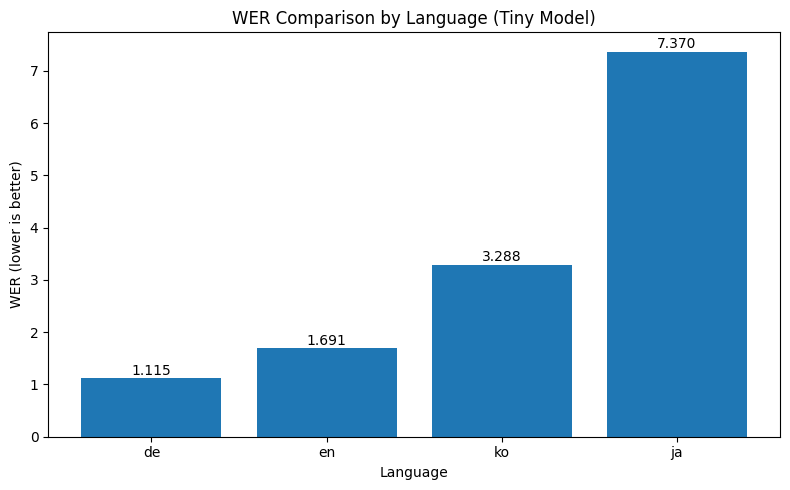

In [12]:
import matplotlib.pyplot as plt

sorted_items = sorted(lang_wer_results.items(), key=lambda x: x[1])
langs_sorted = [x[0] for x in sorted_items]
scores_sorted = [x[1] for x in sorted_items]

plt.figure(figsize=(8, 5))
bars = plt.bar(langs_sorted, scores_sorted)
plt.title("WER Comparison by Language (Tiny Model)")
plt.xlabel("Language")
plt.ylabel("WER (lower is better)")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f"{yval:.3f}", ha='center', va='bottom')

plt.tight_layout()
plt.savefig("wer_comparison_chart_tiny_sorted.png")
plt.show()

- 현재 language=None + forced_decoder_ids=None은 모델이 언어 감지 실패 시 아무 언어로 예측함
- 샘플마다 언어에 맞게 decoder 설정해야 할 듯